# Please read before running
1. Make sure the packages listed below have been properly installed on the machine;
2. Training the machine learning models are time consuming unless a GPU has been used;
3. If you want to run the notebook without training the machine learning models, you may skip the **Model Training** phase and load our trained machine learning models(.pt files).

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import nltk
import math
import re
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from pathlib import Path
from sklearn.metrics import accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
import matplotlib.gridspec as gridspec
import gensim.downloader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [45]:
nltk.download('punkt')
PRETRAINED_WORD_VECTORS = gensim.downloader.load('glove-twitter-25')

[nltk_data] Downloading package punkt to /home/ew067184/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Dataset Analyzing and Construction

In [46]:
dataset = pd.read_pickle('BIOS.pkl')

In [47]:
# dataset size
len(dataset)

394217

In [48]:
# a data instance example
dataset[0]

{'path': 'crawl-data/CC-MAIN-2013-20/segments/1368696381249/wet/CC-MAIN-20130516092621-00000-ip-10-60-113-184.ec2.internal.warc.wet.gz',
 'raw': '* Nora Fisher Onar is an assistant professor of international relations at Bahcesehir University in Istanbul. She is also a Ronald D. Asmus Policy Entrepreneur Fellow with the German Marshall Fund and is a Visiting Fellow at the Centre for International Studies (CIS) at the University of Oxford. This commentary first appeared at Sada, an online journal published by the Carnegie Endowment for International Peace.',
 'name': ('Nora', 'Fisher', 'Onar'),
 'raw_title': 'assistant professor',
 'gender': 'F',
 'start_pos': 109,
 'title': 'professor',
 'URI': 'http://acturca.wordpress.com/2012/04/13/turkey-model-mideast/',
 'bio': '_ is also a Ronald D. Asmus Policy Entrepreneur Fellow with the German Marshall Fund and is a Visiting Fellow at the Centre for International Studies (CIS) at the University of Oxford. This commentary first appeared at Sad

### Text length

In [49]:
# the length of bio-text 'raw'
sens_len = []
for i in dataset:
    text = i['raw'][i['start_pos']:]
    text = text.lower()

    # remove numbers, useless punctuations
    text = re.sub(r"[^a-z!?]", " ", text)
    text = nltk.word_tokenize(text)
    sens_len.append(len(text))

In [50]:
# 99% of data instances have bio-text lenght no longer than text_size
text_size = int(np.percentile(sens_len, 99))
print(text_size)

135


### Distribution of data instance size and gender difference over occupations

In [51]:
# Distribution of occupations in dataset
def occupation_distribution(dataset):
    men_dict = dict()
    women_dict = dict()
    total_dict = dict()
    for i in dataset:
        if i['gender'] == 'M':
            if i['title'] in men_dict:
                men_dict[i['title']] += 1
            else:
                men_dict[i['title']] = 1
        else:
            if i['title'] in women_dict:
                women_dict[i['title']] += 1
            else:
                women_dict[i['title']] = 1
        if i['title'] in total_dict:
            total_dict[i['title']] += 1
        else:
            total_dict[i['title']] = 1

    men_list = []
    women_list = []
    total_dict = dict(sorted(total_dict.items(),reverse = True, key=lambda item: item[1]))
    width = 0.4
    for k,v in total_dict.items():
        men_list.append(men_dict[k])
        women_list.append(women_dict[k])
    fig, ax = plt.subplots(figsize=(20,10))
    plt.xticks(rotation=90)
    labels = total_dict.keys()
    ax.bar(labels, men_list, width, label='Men')
    ax.bar(labels, women_list, width, bottom=men_list,label='Women')
    ax.set_xlabel('Occupation')
    ax.set_ylabel('Number of Instances')
    ax.set_title('Distribution of Occupation and Gender Difference')
    ax.legend()

    plt.show()

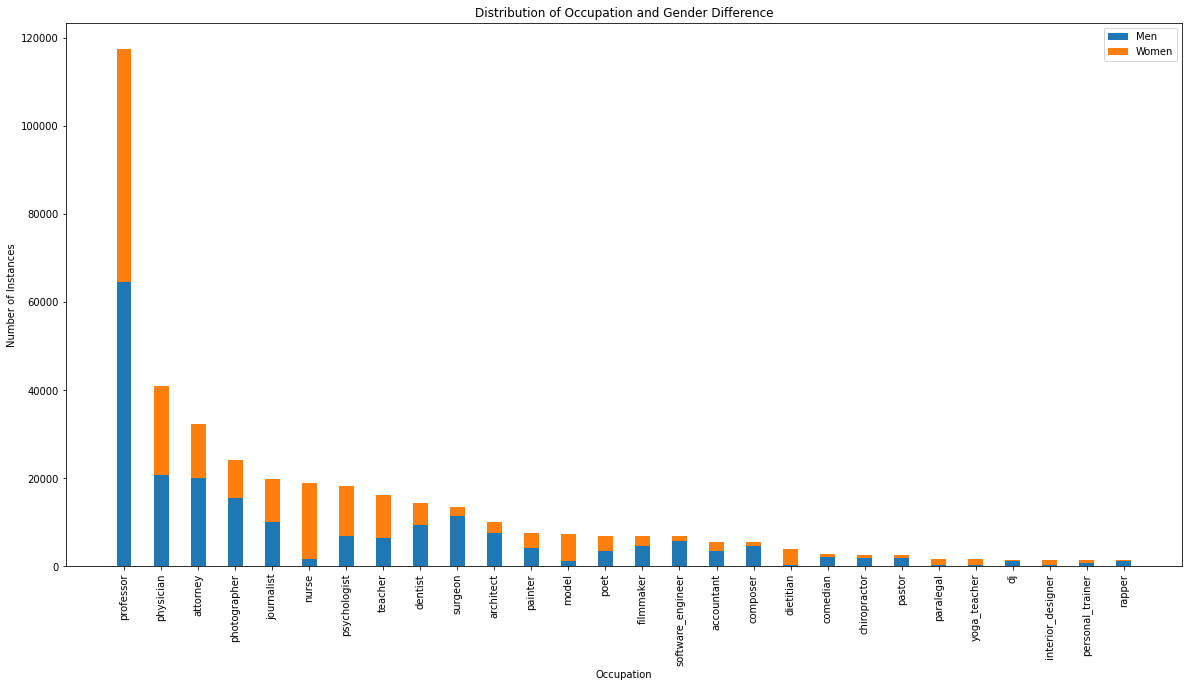

In [52]:
occupation_distribution(dataset)

### Gender difference in occupations

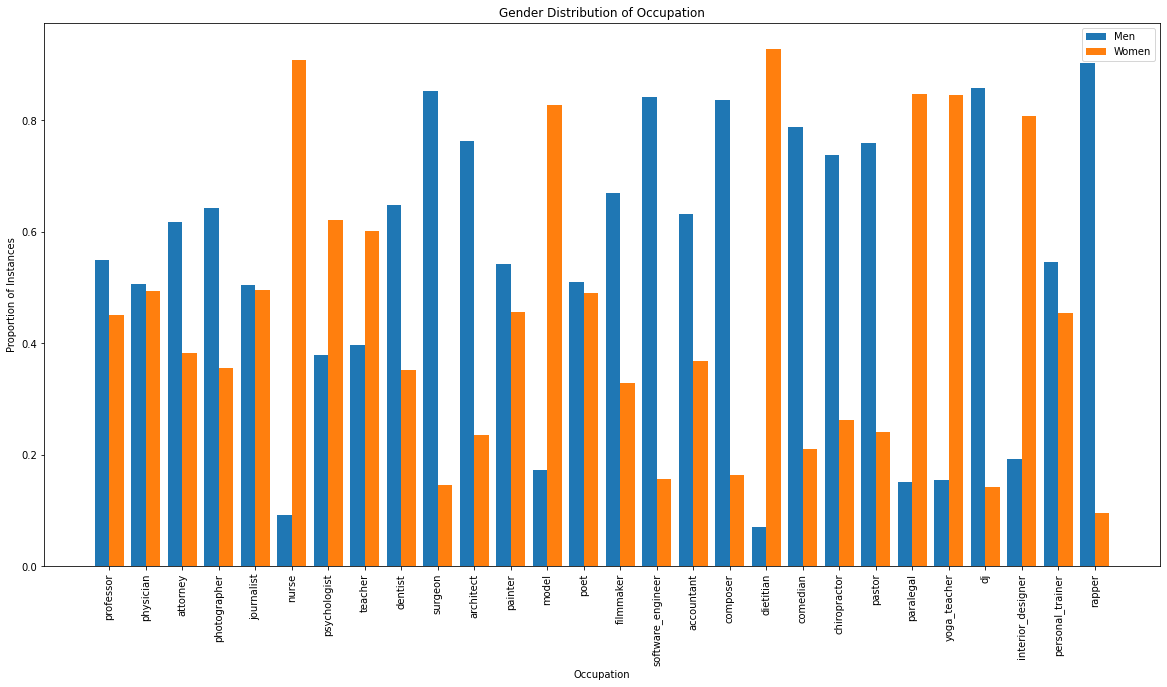

In [53]:
men_dict = dict()
women_dict = dict()
total_dict = dict()
for i in dataset:
    if i['gender'] == 'M':
        if i['title'] in men_dict:
            men_dict[i['title']] += 1
        else:
            men_dict[i['title']] = 1
    else:
        if i['title'] in women_dict:
            women_dict[i['title']] += 1
        else:
            women_dict[i['title']] = 1
    if i['title'] in total_dict:
        total_dict[i['title']] += 1
    else:
        total_dict[i['title']] = 1

men_list = []
women_list = []
total_dict = dict(sorted(total_dict.items(),reverse = True, key=lambda item: item[1]))
width = 0.4
for k,v in total_dict.items():
    men_list.append(men_dict[k])
    women_list.append(women_dict[k])
fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=90)
labels = total_dict.keys()
men_percent = []
women_percent = []
for i in range(len(men_list)):
    men_percent.append(men_list[i]/(men_list[i]+women_list[i]))
    women_percent.append(women_list[i]/(men_list[i]+women_list[i]))

x = np.arange(len(labels))
ax.bar(x - width/2, men_percent, width, label='Men')
ax.bar(x + width/2, women_percent, width, label='Women')
plt.xticks(x,labels,rotation=90)
ax.set_xlabel('Occupation')
ax.set_ylabel('Proportion of Instances')
ax.set_title('Gender Distribution of Occupation')
ax.legend()
plt.show()

In [54]:
# visualize gender difference in different occupations
def gender_diff_graph(dataset):
    men_dict = dict()
    women_dict = dict()
    total_dict = dict()
    for i in dataset:
        if i['gender'] == 'M':
            if i['title'] in men_dict:
                men_dict[i['title']] += 1
            else:
                men_dict[i['title']] = 1
        else:
            if i['title'] in women_dict:
                women_dict[i['title']] += 1
            else:
                women_dict[i['title']] = 1
        if i['title'] in total_dict:
            total_dict[i['title']] += 1
        else:
            total_dict[i['title']] = 1

    men_list = []
    women_list = []
    total_dict = dict(sorted(total_dict.items(),reverse = True, key=lambda item: item[1]))
    width = 0.4
    for k,v in total_dict.items():
        men_list.append(men_dict[k])
        women_list.append(women_dict[k])
    fig, ax = plt.subplots(figsize=(20,10))
    plt.xticks(rotation=90)
    labels = total_dict.keys()
    men_percent = []
    women_percent = []
    for i in range(len(men_list)):
        men_percent.append(men_list[i]/(men_list[i]+women_list[i]))
        women_percent.append(women_list[i]/(men_list[i]+women_list[i]))

    ax.bar(labels, men_percent, width, label='Men')
    ax.bar(labels, women_percent, width, bottom=men_percent,label='Women')
    ax.set_xlabel('Occupation')
    ax.set_ylabel('Proportion of Instances')
    ax.set_title('Distribution of Occupation and Gender Difference')
    ax.legend()

    plt.show()
    return total_dict

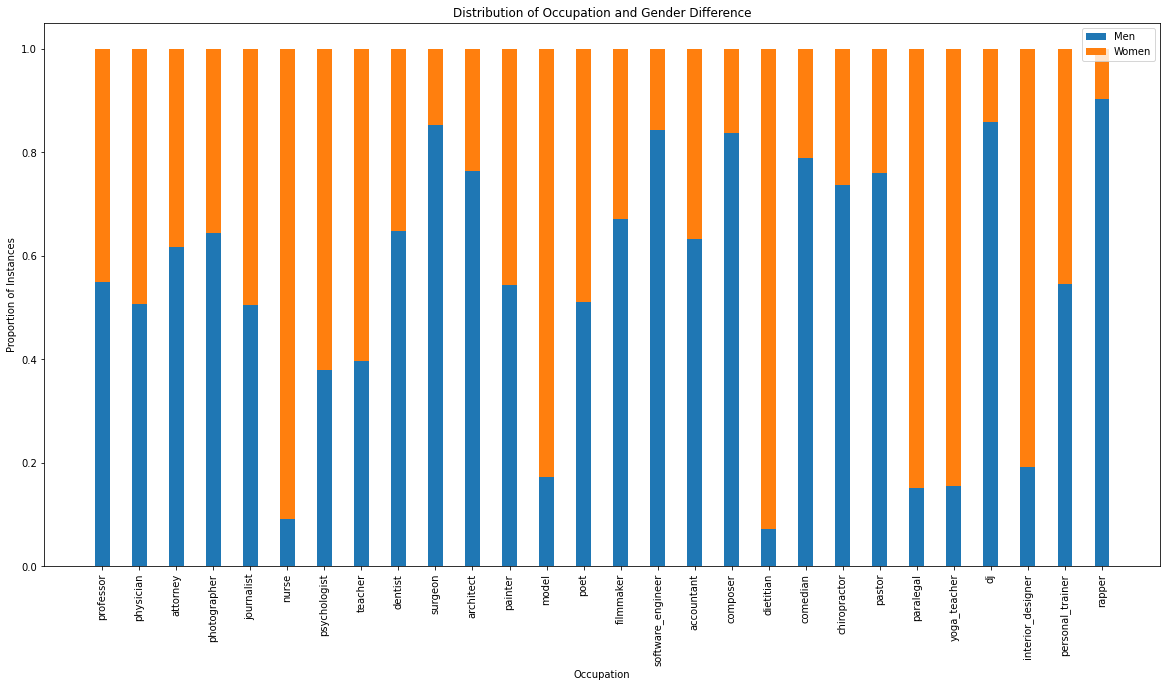

In [55]:
total_dict = gender_diff_graph(dataset)

## Construct dataset for subsampling method

In [56]:
# Distribution of title in dataset and gender difference in groups with different titles
def subsampling(dataset,sample_size):
    np.random.seed(0)
    random.seed(0)
    
    men_dict = dict()
    women_dict = dict()
    total_dict = dict()
    for i in dataset:
        if i['gender'] == 'M':
            if i['title'] in men_dict:
                men_dict[i['title']] += 1
            else:
                men_dict[i['title']] = 1
        else:
            if i['title'] in women_dict:
                women_dict[i['title']] += 1
            else:
                women_dict[i['title']] = 1
        if i['title'] in total_dict:
            total_dict[i['title']] += 1
        else:
            total_dict[i['title']] = 1

    keep_occupation = []
    total_dict = dict(sorted(total_dict.items(),reverse = True, key=lambda item: item[1]))
    width = 0.4
    for k,v in total_dict.items():
        if men_dict[k] >= sample_size and women_dict[k] >= sample_size:
            keep_occupation.append(k)
    train_data_dic = {}

    for data_instance in dataset:
        if data_instance['title'] in keep_occupation:
            if data_instance['title'] in train_data_dic:
                train_data_dic[data_instance['title']].append(data_instance)
            else:
                train_data_dic[data_instance['title']] = [data_instance]

    # upsampling
    train_data_dic_up = train_data_dic
    for key, value in train_data_dic_up.items():
        male_l = []
        female_l = []
        for instance in value:
            if instance['gender']=='F':
                female_l.append(instance)
            else:
                male_l.append(instance)
        female_l = np.random.choice(female_l, sample_size, replace=False)
        male_l = np.random.choice(male_l, sample_size, replace=False)
        male_l = list(male_l)
        female_l =list(female_l)
        male_l.extend(female_l)
        random.shuffle(male_l)
        train_data_dic_up[key] = male_l

    train_data_up = list()
    for key, value in train_data_dic_up.items():
        train_data_up.extend(value)
    return train_data_up

In [57]:
subsample_dataset = subsampling(dataset,3000)

## Train, validation, test data spliting
We have adopted the stratified-by-occupation split due to the large data instance size difference between different occupations. Besides, we split 75% of the data instances of each occupation for training and validation, and 25% for testing. 75% of the data instances will be further splitted in the training phase where 15% of them will be used for validation. Thus the training_data actually refers to training_data + validation_data.

In [58]:
dataset_dic = {}

for data_instance in dataset:
    if data_instance['title'] in dataset_dic:
        dataset_dic[data_instance['title']].append(data_instance)
    else:
        dataset_dic[data_instance['title']] = [data_instance]

In [59]:
subsample_dataset_dic = {}

for data_instance in subsample_dataset:
    if data_instance['title'] in subsample_dataset_dic:
        subsample_dataset_dic[data_instance['title']].append(data_instance)
    else:
        subsample_dataset_dic[data_instance['title']] = [data_instance]

In [60]:
def dataset_split(dataset_dic, train_ratio):
    training_data = []
    testing_data = []

    for key, value in dataset_dic.items():
        # train_ratio for traning and validation
        training_data.extend(value[:int(train_ratio * len(value))])
        # 1-(train_ratio) for test
        testing_data.extend(value[int((train_ratio) * len(value)):])
    
    random.seed(0)
    random.shuffle(training_data)
    random.shuffle(testing_data)
    
    return training_data, testing_data

In [61]:
# 75% for traning and validation, 15% of which will be used for validation 
# 25% for test
train_ratio = 0.75

In [62]:
training_data, testing_data = dataset_split(dataset_dic, train_ratio)

In [63]:
print(len(training_data))
print(len(testing_data))
print(len(training_data)+len(testing_data))

295653
98564
394217


In [64]:
training_subdata, testing_subdata = dataset_split(subsample_dataset_dic, train_ratio)

In [65]:
print(len(training_subdata))
print(len(testing_subdata))

45000
15000


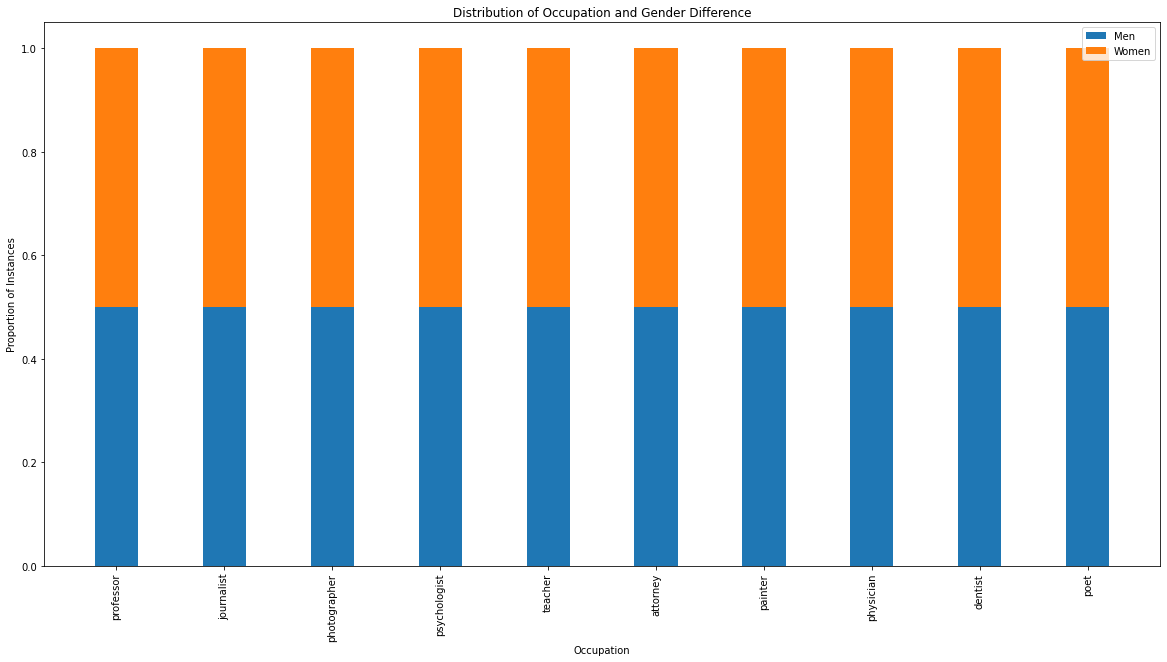

In [66]:
# we can see that the gender distribution is truly balanced by subsampling and the data instances are not duplicated
sub_totaldict = gender_diff_graph(subsample_dataset)

### Occupation-to-classification class encoding

In [67]:
# for 28-class classification
target_encoder = dict()
i = 0
for k,v in total_dict.items():
    target_encoder[k] = i
    i += 1
    
target_encoder

{'professor': 0,
 'physician': 1,
 'attorney': 2,
 'photographer': 3,
 'journalist': 4,
 'nurse': 5,
 'psychologist': 6,
 'teacher': 7,
 'dentist': 8,
 'surgeon': 9,
 'architect': 10,
 'painter': 11,
 'model': 12,
 'poet': 13,
 'filmmaker': 14,
 'software_engineer': 15,
 'accountant': 16,
 'composer': 17,
 'dietitian': 18,
 'comedian': 19,
 'chiropractor': 20,
 'pastor': 21,
 'paralegal': 22,
 'yoga_teacher': 23,
 'dj': 24,
 'interior_designer': 25,
 'personal_trainer': 26,
 'rapper': 27}

In [68]:
# we need a new target encoder for subsampling dataset
# for 10-class classification
sub_target_encoder = dict()
i = 0
for k,v in sub_totaldict.items():
    sub_target_encoder[k] = i
    i += 1
    
sub_target_encoder

{'professor': 0,
 'journalist': 1,
 'photographer': 2,
 'psychologist': 3,
 'teacher': 4,
 'attorney': 5,
 'painter': 6,
 'physician': 7,
 'dentist': 8,
 'poet': 9}

## Construct dataset for upsampling method

In [69]:
random.seed(0)
np.random.seed(0)

# dictionalizing the training data
train_data_dic = {}

for data_instance in training_data:
    if data_instance['title'] in train_data_dic:
        train_data_dic[data_instance['title']].append(data_instance)
    else:
        train_data_dic[data_instance['title']] = [data_instance]

# upsampling
train_data_dic_up = train_data_dic
for key, value in train_data_dic_up.items():
    male_l = []
    female_l = []
    for instance in value:
        if instance['gender']=='F':
            female_l.append(instance)
        else:
            male_l.append(instance)
    if len(male_l) > len(female_l):
        female_l = np.random.choice(female_l, len(male_l), replace=True)
    elif len(male_l) < len(female_l):
        male_l = np.random.choice(male_l, len(female_l), replace=True)
    else:
        pass
    male_l = list(male_l)
    female_l =list(female_l)
    male_l.extend(female_l)
    random.shuffle(male_l)
    train_data_dic_up[key] = male_l

train_data_up = list()
for key, value in train_data_dic_up.items():
    train_data_up.extend(value)

In [70]:
len(train_data_up)

374412

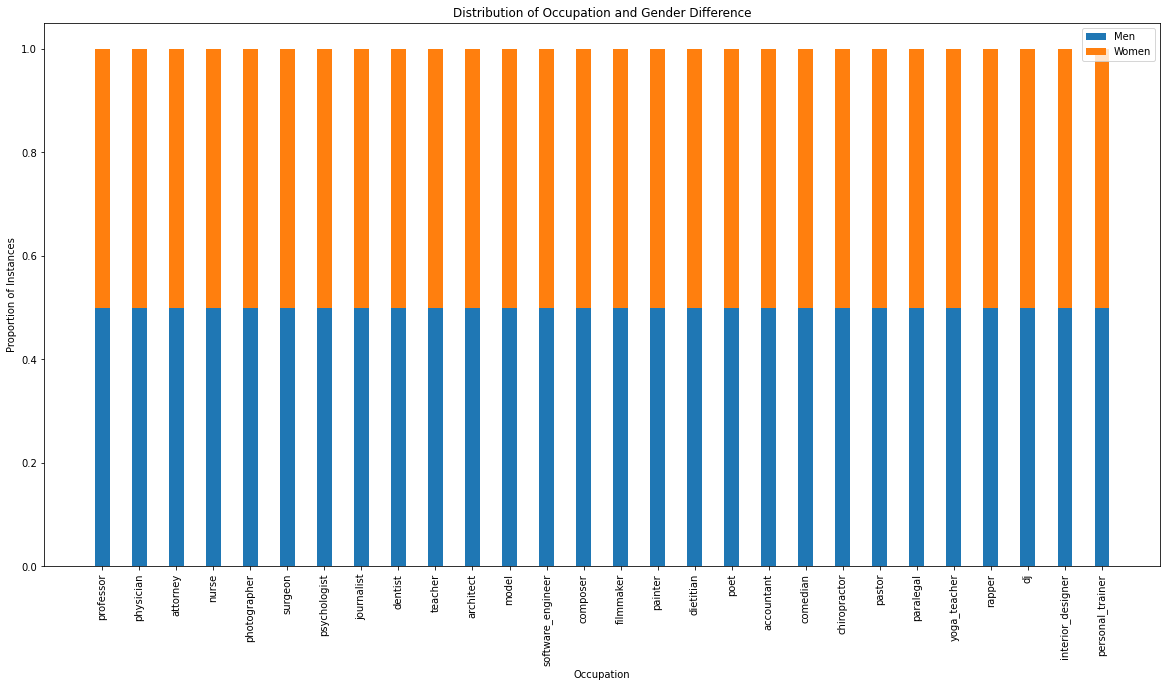

In [71]:
train_dict = gender_diff_graph(train_data_up)

## Testing data preparation

In [72]:
# split testing data into gender groups
def test_data_in_gender(testing_data):
    testing_data_m = []
    testing_data_f = []

    for dic in testing_data:
        if dic['gender'] == 'M':
            testing_data_m.append(dic)
        else:
            testing_data_f.append(dic)
    return testing_data_m, testing_data_f

In [73]:
# for original dataset
testing_data_m, testing_data_f = test_data_in_gender(testing_data)

In [74]:
# for subsampling dataset
testing_data_m_sub, testing_data_f_sub = test_data_in_gender(testing_subdata)

## Gender distribution in occupations of testing data
The result tells us that our training-validation-test split method keeps the relative same gender distribution of occupations as the whole dataset since the process is random.

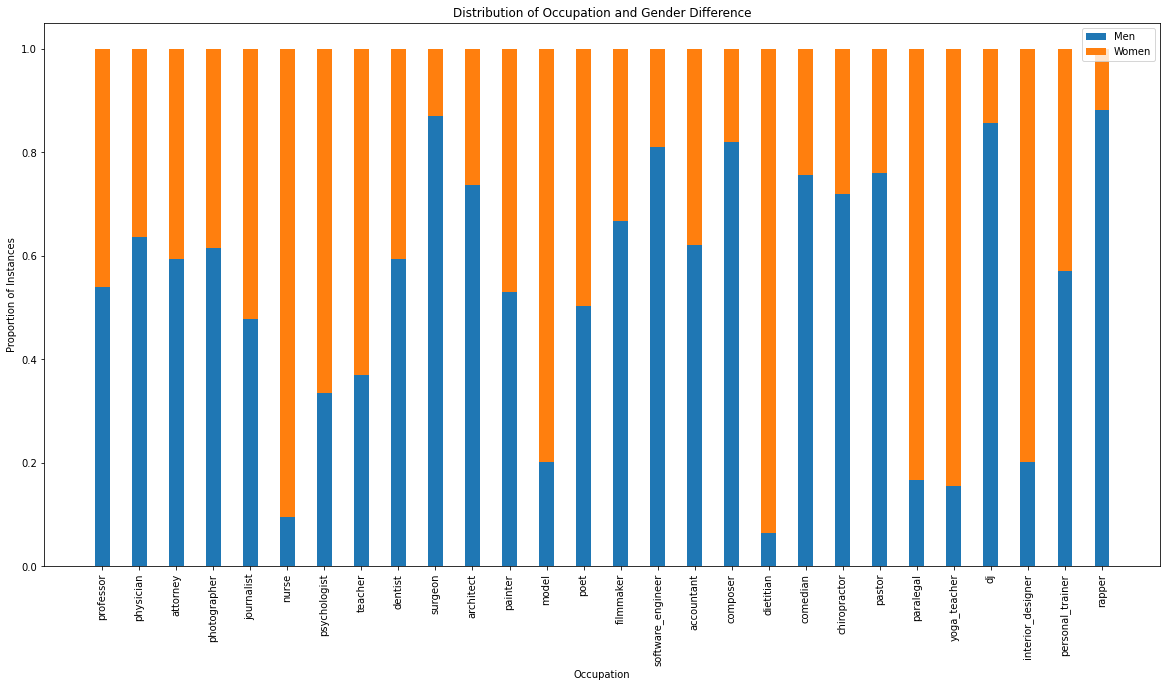

In [75]:
test_dict = gender_diff_graph(testing_data)

### Existing gender imbalance in dataset

In [76]:
# relative size of gender groups in occupations of original dataset
per_occ_men = []
per_occ_women = []

for i in range(len(men_list)):
    per_occ_men.append(men_list[i] / (men_list[i] + women_list[i]))
    per_occ_women.append(women_list[i] / (men_list[i] + women_list[i])) 

gender_gap_in_data = []
for j in range(len(per_occ_men)):
    gender_gap_in_data.append(per_occ_women[j] - per_occ_men[j])

print(gender_gap_in_data)

[-0.09819004909927931, -0.012789474971266479, -0.23418560898127877, -0.28687437852171027, -0.009364615849360547, 0.817062818336163, 0.24180933107258107, 0.2047639724582842, -0.29477196885428253, -0.7063921191022888, -0.5268282988871225, -0.0862561704338789, 0.6556344633525393, -0.019748139668002318, -0.3408927802497488, -0.6849454545454545, -0.2649207197577053, -0.6737919885036825, 0.8569610587935861, -0.577706323687031, -0.47428571428571425, -0.5183121019108281, 0.6957264957264957, 0.6902601330913491, -0.7168021680216803, 0.6143250688705235, -0.0921885995777621, -0.8074712643678161]


In [77]:
# relative size of gender groups in occupations of subsampling dataset
sub_per_occ_women = []
keys = sub_target_encoder.keys()
for i in keys:
    sub_per_occ_women.append(per_occ_women[target_encoder[i]])
sub_per_occ_women

[0.45090497545036035,
 0.4953176920753197,
 0.35656281073914486,
 0.6209046655362905,
 0.6023819862291421,
 0.38290719550936064,
 0.45687191478306055,
 0.49360526251436676,
 0.3526140155728587,
 0.49012593016599887]

# 2. Data Preprocessing

In [78]:
# custom pytorch dataset object
class Dataset(Dataset):
    def __init__(self, text, labels):
        self.text = text
        self.labels = labels
        self.length = len(text)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        data = torch.tensor(self.text[index], dtype=torch.long)
        labels = torch.tensor(self.labels[index], dtype=torch.long)
        return data, labels

In [79]:
def preprocess(text, vocab, flip:bool = False, sex = None):
    # lower case
    text = text.lower()
    # remove numbers, useless punctuations
    text = re.sub(r"[^a-z!?]", " ", text)
    # tokenize
    text = nltk.word_tokenize(text)
    
    # flipping
    if flip:
        for i in range(len(text)):
            if sex == 'F':
                if text[i] == 'she':
                    text[i] = 'he'
                if text[i] == 'her':
                    text[i] = 'him'
                if text[i] == 'hers':
                    text[i] = 'his'
                if text[i] == 'herself':
                    text[i] = 'himself'
                if text[i] == 'mrs':
                    text[i] = 'mr'
                if text[i] == 'ms':
                    text[i] = 'mr'
            else:
                if text[i] == 'he':
                    text[i] = 'she'
                if text[i] == 'him':
                    text[i] = 'her'
                if text[i] == 'his':
                    text[i] = 'her'
                if text[i] == 'himself':
                    text[i] = 'herself'
                if text[i] == 'mr':
                    text[i] = 'ms'
                    
    # indexing
    pad_idx = 0
    text_index = []
    for word in text:
        if word in vocab.keys():
            text_index.append(vocab[word])
        else:
            # unknown
            text_index.append(1)
   
    return text_index

In [80]:
def get_dataset(train_dict:list, target_encoder:dict, params:dict, bio:bool = False, flip:bool = False):
    print("Processing data...")
    
    vocab = PRETRAINED_WORD_VECTORS.key_to_index
    padded_index = []
    labels = []
    for x in list(train_dict):
        if bio:
            text = x['bio']
        else:
            text = x['raw'][x['start_pos']:]
        index_matrix = preprocess(text,vocab,flip,sex = x['gender'])
        padded_index.append(index_matrix)
        labels.append(target_encoder[x['title']])
    text_size = params['text_size']
    
    # padding
    for i in range(len(padded_index)):
        text_index = padded_index[i]
        if len(text_index) > text_size:
            padded_index[i] = text_index[:text_size]
        else:
            padded_index[i] = text_index+[0]*(text_size-len(text_index))

    data = Dataset(np.array(padded_index),labels)
    print("Loading completed!")
    
    return data

# 3. Machine Learning Models

In [81]:
# word embedding + cnn
# part of the code cited from https://github.com/Shawn1993/cnn-text-classification-pytorch
class CNN(nn.Module):
    def __init__(self, params, freeze = False, pre = True):
        super(CNN, self).__init__()
        
        vocab_size = params['vocab_size']
        embedding_size = params['embedding_size']
        class_size = params['class_size'] 
        inp_ch = params['in_channel']
        outp_ch = params['out_channel'] 
        kernels = params['kernels']
        dropout_rate = params['dropout_rate']
        
        # using pretrained GloVe word vectors
        if pre == True:
            self.embed = nn.Embedding.from_pretrained(torch.FloatTensor(PRETRAINED_WORD_VECTORS.vectors), freeze = freeze, padding_idx = 0)
        # random initialization
        else:
            self.embed = nn.Embedding(vocab_size, embedding_size)
        
        self.convs = nn.ModuleList([nn.Conv2d(inp_ch, outp_ch, (k, embedding_size)) for k in kernels])
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(len(kernels) * outp_ch, class_size)
        
    def forward(self,x):
        x = self.embed(x) 
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]      
        x = [F.max_pool1d(i, int(i.size(2))).squeeze(2) for i in x] 
        x = torch.cat(x,1)
        x = self.dropout(x)
        logit = self.fc(x)

        return logit

In [82]:
# word embedding + logistic regression
class LR(nn.Module):
    def __init__(self, params, pretrain = True, freeze = False):
        super(LR, self).__init__()
        vocab_size = params['vocab_size']
        embedding_size = params['embedding_size']
        class_size = params['class_size']
        
        if pretrain:
            self.embed = nn.Embedding.from_pretrained(torch.FloatTensor(PRETRAINED_WORD_VECTORS.vectors), freeze=freeze)
        else:
            self.embed = nn.Embedding(vocab_size,embedding_size)
        
        self.linear = nn.Linear(embedding_size, class_size)

    def forward(self, idx_matric):
        idx_matric = self.embed(idx_matric)
        idx_matric = torch.mean(idx_matric, 1)
        out = self.linear(idx_matric)
        return out

In [83]:
def train_model(cnn_instance:CNN, dataset, params, max_train_time:float):
    cuda = params['cuda']
    
    if cuda:
        cnn_instance.cuda()
        
    end_time = time.time() + max_train_time
    
    optimizer = optim.Adam(cnn_instance.parameters(), lr = params['learning_rate'])
    
    # training-validation split
    valid_size = int(0.15 * len(dataset))
    train_size = len(dataset) - valid_size
    train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size], generator=torch.Generator().manual_seed(42))
    train_iter = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    
    n_epoch = params['n_epoch']
    steps = 0
    
    loss_list = []
    acc_list = []
    
    print("Start training...")
    for epoch in range(1, n_epoch+1):
        cnn_instance.train()
        for data, labels in train_iter:
            if cuda:
                data, labels = data.cuda(), labels.cuda()
            y_pred = cnn_instance(data)
            loss = F.cross_entropy(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            steps += 1
            true_labels = []
            inf_labels = []
            cls = torch.argmax(F.softmax(y_pred, dim=1), dim=1)
            inf_labels.extend(cls.cpu().detach().numpy().tolist())
            true_labels.extend(labels.cpu().numpy().tolist())
                
            loss_list.append(loss.data.item())
            acc_list.append(accuracy_score(true_labels, inf_labels))
                
        cnn_instance.eval()
        true_labels = []
        inf_labels = []
        steps =0
        avg_loss = 0
        
        # evaluate
        for data, labels in DataLoader(valid_dataset, batch_size=100):
            if cuda:
                data, labels = data.cuda(), labels.cuda()
            out = cnn_instance(data)
            cls = torch.argmax(F.softmax(out, dim=1), dim=1)
            loss = F.cross_entropy(out, labels)
            avg_loss += loss.item()
            inf_labels.extend(cls.cpu().detach().numpy().tolist())
            true_labels.extend(labels.cpu().numpy().tolist())

        size = len(valid_dataset)
        avg_loss /= size
        acc = accuracy_score(true_labels, inf_labels)
        print('\rEval: - loss: {:.6f} acc: {:.4f}'.format(avg_loss, acc))
        if time.time() > end_time:
            break
            
    print("Training completed!")
    
    # visualizing traning loss
    plt.plot(loss_list, 'g', label='Training loss')
    plt.plot(acc_list, 'b', label='Training accuracy')
    plt.title('Training loss and accuracy')
    plt.xlabel('Batch')
    plt.legend()
    plt.show()

# 4. Model Training

### Models and their respective configurations
**cnn.pt** (pretrained GloVe word vectors+ CNN + trained and tested on 'raw' of original dataset)<br>
**cnn_nopre.pt** (random initialized word vectors + CNN + trained and tested on 'raw' of original dataset)<br>
**LR.pt** (pretrained GloVe word vectors+ LR + trained and tested on 'raw' of original dataset)<br>
**LR_nopre.pt** (random initialized word vectors + CNN + trained and tested on 'raw' of original dataset)<br>
**cnn_up.pt** (pretrained GloVe word vectors+ CNN + trained and tested on 'raw' of upsampling dataset)<br>
**LR_up.pt** (pretrained GloVe word vectors+ LR + trained and tested on 'raw' of upsampling dataset)<br>
**cnn_bio.pt** (pretrained GloVe word vectors+ CNN + trained and tested on 'bio' of original dataset)<br>
**LR_bio.pt** (pretrained GloVe word vectors+ LR + trained and tested on 'bio' of original dataset)<br>
**cnn_flip.pt** (pretrained GloVe word vectors+ CNN + trained on flipped 'raw' and tested on 'raw' of original dataset)<br>
**LR_flip.pt** (pretrained GloVe word vectors+ LR + trained on flipped 'raw' and tested on 'raw' of original dataset)<br>
**cnn_sub.pt** (pretrained GloVe word vectors+ CNN + trained and tested on 'raw' of subsampling dataset)<br>
**LR_sub.pt** (pretrained GloVe word vectors+ LR + trained and tested on 'raw' of subsampling dataset)<br>

In [85]:
# hyperparameters to tune
# hyperparameters for training models except for subsampling method
PARAMS = {
    'vocab_size' : len(PRETRAINED_WORD_VECTORS), # vocabulary size, actual vocabulary+<UNKNOWN>+pad_idx
    'embedding_size' : 25, # embedding size
    'text_size' : 135, # max length of a single text
    'kernels' : [5,6,7], # kernals
    'batch_size' : 128, # batch size
    'n_epoch' : 10, # number of epochs we train
    'class_size' : len(target_encoder), # number of classification results
    'dropout_rate' : 0.25, # dropput rate
    'learning_rate'  : 0.001, # learning rate
    'in_channel' : 1, # input channel
    'out_channel' : 100, # output channnel
    'cuda' : True  # whether or not train using GPU, set true if yes
}

In [42]:
# prepare training dataset
train_dataset = get_dataset(training_data,target_encoder,PARAMS) 

Processing data...
Loading completed!


### Train cnn.pt

Start training...


/home/ew067184/.local/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Eval: - loss: 0.007260 acc: 0.7838
Eval: - loss: 0.006652 acc: 0.8022
Eval: - loss: 0.006457 acc: 0.8079
Eval: - loss: 0.006331 acc: 0.8125
Eval: - loss: 0.006460 acc: 0.8090
Eval: - loss: 0.006558 acc: 0.8104
Eval: - loss: 0.006762 acc: 0.8099
Eval: - loss: 0.006985 acc: 0.8071
Eval: - loss: 0.007256 acc: 0.8051
Eval: - loss: 0.007622 acc: 0.8020
Training completed!


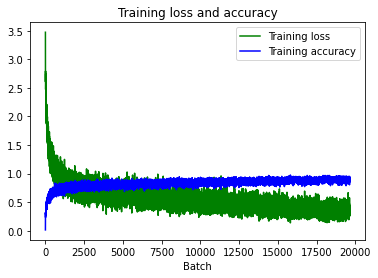

In [43]:
# pretrained GloVe+CNN trained on 'raw' of original dataset
cnn_inst = CNN(PARAMS) 
train_model(cnn_inst,train_dataset,PARAMS,0.5 * 3600)
torch.save(cnn_inst.cpu().state_dict(),"cnn.pt")

### Train cnn_nopre.pt

Start training...
Eval: - loss: 0.009652 acc: 0.7151
Eval: - loss: 0.008020 acc: 0.7643
Eval: - loss: 0.007520 acc: 0.7783
Eval: - loss: 0.007190 acc: 0.7878
Eval: - loss: 0.007082 acc: 0.7919
Eval: - loss: 0.007038 acc: 0.7931
Eval: - loss: 0.007104 acc: 0.7928
Eval: - loss: 0.007094 acc: 0.7960
Eval: - loss: 0.007164 acc: 0.7962
Eval: - loss: 0.007276 acc: 0.7941
Training completed!


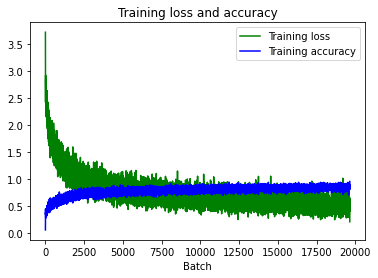

In [44]:
# random initiailization+CNN trained on 'raw' of original dataset
cnn_inst_nopre = CNN(PARAMS,pre = False) 
train_model(cnn_inst_nopre, train_dataset,PARAMS, 0.5 * 3600) 
torch.save(cnn_inst_nopre.cpu().state_dict(), "cnn_nopre.pt")

### Train LR.pt

Start training...
Eval: - loss: 0.016017 acc: 0.5694
Eval: - loss: 0.012029 acc: 0.6589
Eval: - loss: 0.010094 acc: 0.7174
Eval: - loss: 0.009006 acc: 0.7478
Eval: - loss: 0.008342 acc: 0.7622
Eval: - loss: 0.007893 acc: 0.7786
Eval: - loss: 0.007589 acc: 0.7863
Eval: - loss: 0.007371 acc: 0.7923
Eval: - loss: 0.007206 acc: 0.7948
Eval: - loss: 0.007070 acc: 0.8005
Training completed!


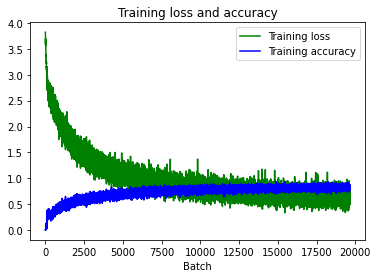

In [45]:
# pretrained GloVe+LR trained on 'raw' of original dataset
LR_inst = LR(PARAMS)
train_model(LR_inst, train_dataset,PARAMS, 0.5 * 3600)
torch.save(LR_inst.cpu().state_dict(), "LR.pt")

### Train LR_nopre.pt

Start training...
Eval: - loss: 0.017940 acc: 0.5169
Eval: - loss: 0.013674 acc: 0.6182
Eval: - loss: 0.011303 acc: 0.6848
Eval: - loss: 0.009901 acc: 0.7208
Eval: - loss: 0.009037 acc: 0.7489
Eval: - loss: 0.008487 acc: 0.7622
Eval: - loss: 0.008104 acc: 0.7714
Eval: - loss: 0.007816 acc: 0.7820
Eval: - loss: 0.007596 acc: 0.7861
Eval: - loss: 0.007421 acc: 0.7907
Training completed!


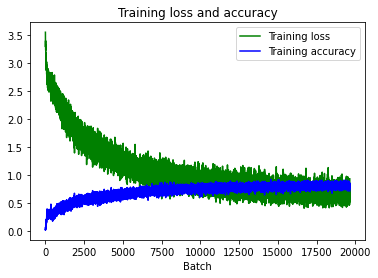

In [46]:
# random initialization+CNN trained on 'raw' of original dataset
LR_inst_nopre = LR(PARAMS,pretrain=False)
train_model(LR_inst_nopre, train_dataset,PARAMS, 0.5 * 3600)
torch.save(LR_inst_nopre.cpu().state_dict(), "LR_nopre.pt") 

In [47]:
train_dataset_up = get_dataset(train_data_up,target_encoder,PARAMS) 

Processing data...
Loading completed!


### Train cnn_up.pt

Start training...
Eval: - loss: 0.007032 acc: 0.7945
Eval: - loss: 0.006152 acc: 0.8184
Eval: - loss: 0.005647 acc: 0.8365
Eval: - loss: 0.005407 acc: 0.8454
Eval: - loss: 0.005333 acc: 0.8513
Eval: - loss: 0.005304 acc: 0.8563
Eval: - loss: 0.005365 acc: 0.8581
Eval: - loss: 0.005487 acc: 0.8604
Eval: - loss: 0.005590 acc: 0.8621
Eval: - loss: 0.005790 acc: 0.8608
Training completed!


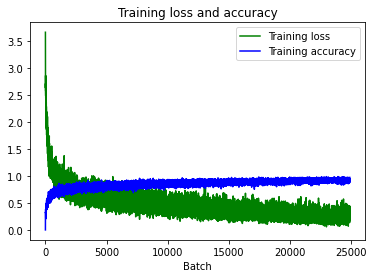

In [48]:
# pretrained GloVe+CNN trained on 'raw' of upsampling dataset
cnn_inst_up = CNN(PARAMS)
train_model(cnn_inst_up, train_dataset_up,PARAMS, 0.5 * 3600)
torch.save(cnn_inst_up.cpu().state_dict(), "cnn_up.pt")

### Train LR_up.pt

Start training...
Eval: - loss: 0.015461 acc: 0.5673
Eval: - loss: 0.011414 acc: 0.6826
Eval: - loss: 0.009464 acc: 0.7364
Eval: - loss: 0.008405 acc: 0.7671
Eval: - loss: 0.007726 acc: 0.7845
Eval: - loss: 0.007255 acc: 0.7966
Eval: - loss: 0.006902 acc: 0.8084
Eval: - loss: 0.006626 acc: 0.8151
Eval: - loss: 0.006396 acc: 0.8217
Eval: - loss: 0.006216 acc: 0.8269
Training completed!


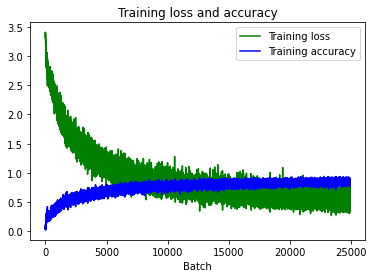

In [49]:
# pretrained GloVe+LR trained on 'raw' of upsampling dataset
LR_inst_up = LR(PARAMS)
train_model(LR_inst_up, train_dataset_up,PARAMS, 0.5 * 3600)
torch.save(LR_inst_up.cpu().state_dict(), "LR_up.pt")

In [50]:
train_dataset_bio = get_dataset(training_data,target_encoder,PARAMS,bio = True) 

Processing data...
Loading completed!


### Train cnn_bio.pt

Start training...
Eval: - loss: 0.007486 acc: 0.7786
Eval: - loss: 0.006804 acc: 0.7967
Eval: - loss: 0.006581 acc: 0.8035
Eval: - loss: 0.006522 acc: 0.8068
Eval: - loss: 0.006554 acc: 0.8065
Eval: - loss: 0.006778 acc: 0.8036
Eval: - loss: 0.006925 acc: 0.8028
Eval: - loss: 0.007197 acc: 0.8012
Eval: - loss: 0.007478 acc: 0.8000
Eval: - loss: 0.007798 acc: 0.7967
Training completed!


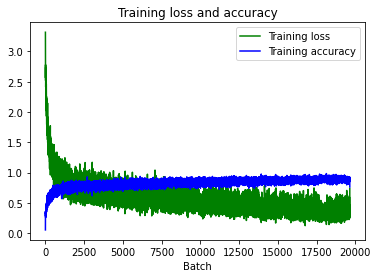

In [51]:
# pretrained GloVe+CNN trained on 'bio' of original dataset
cnn_inst_bio = CNN(PARAMS)
train_model(cnn_inst_bio, train_dataset_bio, PARAMS,0.5 * 3600)
torch.save(cnn_inst_bio.cpu().state_dict(), "cnn_bio.pt")

### Train LR_bio.pt

Start training...
Eval: - loss: 0.016151 acc: 0.5560
Eval: - loss: 0.012079 acc: 0.6614
Eval: - loss: 0.010117 acc: 0.7140
Eval: - loss: 0.009051 acc: 0.7454
Eval: - loss: 0.008401 acc: 0.7623
Eval: - loss: 0.007977 acc: 0.7740
Eval: - loss: 0.007665 acc: 0.7831
Eval: - loss: 0.007458 acc: 0.7871
Eval: - loss: 0.007282 acc: 0.7950
Eval: - loss: 0.007146 acc: 0.7966
Training completed!


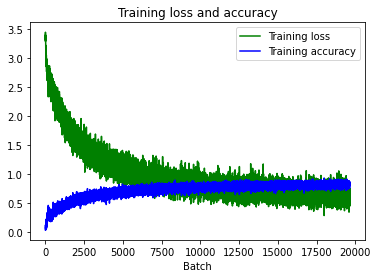

In [52]:
# pretrained GloVe+LR trained on 'bio' of original dataset
LR_inst_bio = LR(PARAMS)
train_model(LR_inst_bio, train_dataset_bio,PARAMS, 0.5 * 3600)
torch.save(LR_inst_bio.cpu().state_dict(), "LR_bio.pt")

In [53]:
train_dataset_flip = get_dataset(training_data,target_encoder,PARAMS,flip = True) 

Processing data...
Loading completed!


### Train cnn_flip.pt

Start training...
Eval: - loss: 0.007359 acc: 0.7813
Eval: - loss: 0.006597 acc: 0.8027
Eval: - loss: 0.006429 acc: 0.8080
Eval: - loss: 0.006357 acc: 0.8111
Eval: - loss: 0.006371 acc: 0.8126
Eval: - loss: 0.006575 acc: 0.8108
Eval: - loss: 0.006732 acc: 0.8079
Eval: - loss: 0.006961 acc: 0.8072
Eval: - loss: 0.007346 acc: 0.8035
Eval: - loss: 0.007627 acc: 0.8018
Training completed!


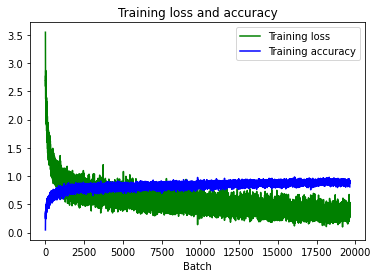

In [54]:
# pretrained GloVe+CNN trained on explicit gender indicators flipped 'raw' text of original dataset
cnn_inst_flip = CNN(PARAMS) 
train_model(cnn_inst_flip, train_dataset_flip,PARAMS, 0.5 * 3600)
torch.save(cnn_inst_flip.cpu().state_dict(), "cnn_flip.pt")

### Train LR_flip.pt

Start training...
Eval: - loss: 0.016044 acc: 0.5559
Eval: - loss: 0.012059 acc: 0.6565
Eval: - loss: 0.010100 acc: 0.7157
Eval: - loss: 0.009013 acc: 0.7485
Eval: - loss: 0.008349 acc: 0.7643
Eval: - loss: 0.007922 acc: 0.7751
Eval: - loss: 0.007609 acc: 0.7847
Eval: - loss: 0.007382 acc: 0.7898
Eval: - loss: 0.007217 acc: 0.7944
Eval: - loss: 0.007083 acc: 0.7980
Training completed!


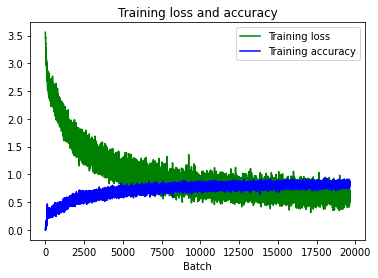

In [55]:
# pretrained GloVe+LR trained on explicit gender indicators flipped 'raw' text of original dataset
LR_inst_flip = LR(PARAMS)
train_model(LR_inst_flip, train_dataset_flip,PARAMS, 0.5 * 3600)
torch.save(LR_inst_flip.cpu().state_dict(), "LR_flip.pt")

In [86]:
# hyperparameters to tune
# hyperparameters for training model on subsampling dataset
SUB_PARAMS = {
    'vocab_size' : len(PRETRAINED_WORD_VECTORS), # vocabulary size, actual vocabulary+<UNKNOWN>+pad_idx
    'embedding_size' : 25, # embedding size
    'text_size' : 135, # max length of a single text
    'kernels' : [5,6,7], # kernals
    'batch_size' : 128, # batch size
    'n_epoch' : 10, # number of epochs we train
    'class_size' : len(sub_target_encoder), # number of classification results
    'dropout_rate' : 0.25, # dropput rate
    'learning_rate'  : 0.001, # learning rate
    'in_channel' : 1, # input channel
    'out_channel' : 100, # output channnel
    'cuda' : True # whether or not train using GPU, set true if yes
}

In [57]:
train_dataset_sub = get_dataset(training_subdata,sub_target_encoder,SUB_PARAMS) 

Processing data...
Loading completed!


### Train cnn_sub.pt

Start training...
Eval: - loss: 0.007993 acc: 0.7514
Eval: - loss: 0.006106 acc: 0.8147
Eval: - loss: 0.005664 acc: 0.8258
Eval: - loss: 0.005544 acc: 0.8302
Eval: - loss: 0.005514 acc: 0.8287
Eval: - loss: 0.005480 acc: 0.8350
Eval: - loss: 0.005574 acc: 0.8350
Eval: - loss: 0.005736 acc: 0.8323
Eval: - loss: 0.005970 acc: 0.8327
Eval: - loss: 0.006331 acc: 0.8250
Training completed!


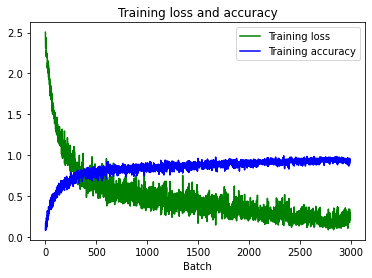

In [58]:
# pretrained GloVe+CNN trained on 'raw' text of subsampling dataset
cnn_inst_sub = CNN(SUB_PARAMS) 
train_model(cnn_inst_sub, train_dataset_sub,SUB_PARAMS, 0.5 * 3600)
torch.save(cnn_inst_sub.cpu().state_dict(), "cnn_sub.pt")

### Train LR_up.pt

Start training...
Eval: - loss: 0.021776 acc: 0.3012
Eval: - loss: 0.019282 acc: 0.4581
Eval: - loss: 0.016516 acc: 0.6073
Eval: - loss: 0.014238 acc: 0.6686
Eval: - loss: 0.012482 acc: 0.7076
Eval: - loss: 0.011130 acc: 0.7385
Eval: - loss: 0.010076 acc: 0.7569
Eval: - loss: 0.009246 acc: 0.7698
Eval: - loss: 0.008585 acc: 0.7794
Eval: - loss: 0.008042 acc: 0.7876
Training completed!


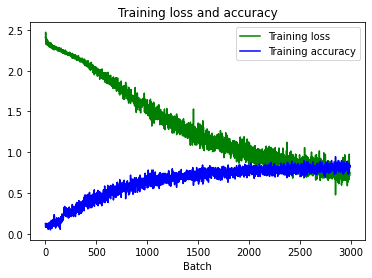

In [59]:
# pretrained GloVe+LR trained on 'raw' text of subsampling dataset
LR_inst_sub = LR(SUB_PARAMS)
train_model(LR_inst_sub, train_dataset_sub,SUB_PARAMS, 0.5 * 3600)
torch.save(LR_inst_sub.cpu().state_dict(), "LR_sub.pt")

# 5. Testing and Results Analyzing

## 5.1 Testing data loading

In [87]:
# test_dataset from 'raw' of original dataset
test_dataset = get_dataset(testing_data,target_encoder,PARAMS)

Processing data...
Loading completed!


In [88]:
# test_dataset from the 'bio' of original dataset
test_dataset_bio = get_dataset(testing_data,target_encoder,PARAMS,bio = True)

Processing data...
Loading completed!


In [89]:
# test instances of male and female groups
test_m = get_dataset(testing_data_m,target_encoder,PARAMS)
test_f = get_dataset(testing_data_f,target_encoder,PARAMS)

Processing data...
Loading completed!
Processing data...
Loading completed!


In [90]:
# test_dataset from the subsampling dataset
test_dataset_sub = get_dataset(testing_subdata, sub_target_encoder,SUB_PARAMS)

Processing data...
Loading completed!


In [91]:
# test instances of male and female groups
test_m_sub = get_dataset(testing_data_m_sub,sub_target_encoder,SUB_PARAMS)
test_f_sub = get_dataset(testing_data_f_sub,sub_target_encoder,SUB_PARAMS)

Processing data...
Loading completed!
Processing data...
Loading completed!


## 5.2 Model performance evaluating

In [92]:
def evaluate(clf, test_data):
    true_labels = []
    inf_labels = []
    
    for data, labels in DataLoader(test_data, batch_size=100):
        out = clf(data)
        cls = torch.argmax(F.softmax(out, dim=1), dim=1)
        inf_labels.extend(cls.detach().numpy().tolist())
        true_labels.extend(labels.numpy().tolist())

    return accuracy_score(true_labels, inf_labels)

## 5.3 Testing, Visualization and Analyzing

In [93]:
# testing to get predicted and true labels for all test instances so that the confusion matrix can be determined
def test_results(clf, test_data):
    y_pred = []
    y_true = []

    for data, labels in DataLoader(test_data):
        out = clf(data)
        cls = torch.argmax(F.softmax(out, dim=1), dim=1)
        y_pred.extend(cls.detach().numpy().tolist())
        y_true.extend(labels.numpy().tolist())
    return y_pred, y_true

In [94]:
# calculate TPR and FPR
# part of the code are from https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py
def metrics(cnf_matrix):
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP) 
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    FPR = FP/(FP+TN)
    FNR = FN/(TP+FN)
    FDR = FP/(TP+FP)
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    return TPR, FPR

In [95]:
# visualize TPR and FPR
def draw_tpr_fpr(labels, tpr_m, tpr_f, fpr_m, fpr_f, name):
    fig = plt.figure(figsize=(20,20),tight_layout=True)
    gs = gridspec.GridSpec(2,2)

    tpr_man_list = []
    tpr_woman_list = []
    for i in range(len(tpr_m)):
        tpr_man_list.append(tpr_m[i])
        tpr_woman_list.append(tpr_f[i])

    ax = fig.add_subplot(gs[0,0])
    x = np.arange(len(labels))  # the label locations
    ax.bar(x - width/2, tpr_man_list, width, label='Men')
    ax.bar(x + width/2, tpr_woman_list, width, label='Women')
    ax.set_xlabel('Occupation')
    ax.set_ylabel('True Positive Rate')
    plt.xticks(x,labels,rotation=90)
    ax.set_title('TPR in Different Gender Group')
    ax.legend()
    
    fpr_man_list = []
    fpr_woman_list = []
    for i in range(len(fpr_m)):
        fpr_man_list.append(fpr_m[i])
        fpr_woman_list.append(fpr_f[i])
    
    ax1 = fig.add_subplot(gs[0,1])
    ax1.bar(x - width/2, fpr_man_list, width, label='Men')
    ax1.bar(x + width/2, fpr_woman_list, width, label='Women')
    ax1.set_xlabel('Occupation')
    ax1.set_ylabel('False Positive Rate')
    plt.xticks(x,labels,rotation=90)
    ax1.set_title('FPR in Different Gender Group')
    ax1.legend()

In [96]:
# visualiza TPR gender gap and FPR gender gap
def draw_gender_gap(labels, TPR_GAP, FPR_GAP, name):
    # draw tpr gender gap and fpr gender gap
    fig = plt.figure(figsize=(20,20),tight_layout=True)
    gs = gridspec.GridSpec(2,2)
    
    ax = fig.add_subplot(gs[0,0])
    x = np.arange(len(labels))
    ax.bar(labels, TPR_GAP)
    ax.set_xlabel('Occupation')
    ax.set_ylabel('TPR Gender Gap')
    ax.set_title('TPR Gender Gap in Different Occupation')
    plt.xticks(x,labels,rotation=90)

    ax1 = fig.add_subplot(gs[0,1])
    ax1.bar(labels, FPR_GAP)
    ax1.set_xlabel('Occupation')
    ax1.set_ylabel('FPR Gender Gap')
    ax1.set_title('FPR Gender Gap in Different Occupation')
    plt.xticks(x,labels,rotation=90)

In [97]:
# visualize correlation between TPR gender gap and percent of women in data as well as between FPR gender gap and percent of women in data
def draw_correl(labels, per_occ_women, TPR_GAP, FPR_GAP, name):
    fig = plt.figure(figsize=(20,20),tight_layout=True)
    gs = gridspec.GridSpec(2, 2)

    ax = fig.add_subplot(gs[0,0])
    ax.scatter(per_occ_women,TPR_GAP,color='red')
    ax.set_xlabel('Percent of Women in Data')
    ax.set_ylabel('TPR Gender Gap')
    ax.set_title('Correlation between TPR Gender Gap and Gender Gap in Data')
    for i in range(len(labels)):
        ax.annotate(labels[i],(per_occ_women[i],TPR_GAP[i]),fontsize=10)
    
    ax1 = fig.add_subplot(gs[0,1])
    ax1.scatter(per_occ_women,FPR_GAP,color='red')
    ax1.set_xlabel('Percent of Women in Data')
    ax1.set_ylabel('FPR Gender Gap')
    ax1.set_title('Correlation between FPR Gender Gap and Gender Gap in Data')
    for i in range(len(labels)):
        ax1.annotate(labels[i],(per_occ_women[i],FPR_GAP[i]),fontsize=10)

In [98]:
# calculate gender bias metrics including: aTPR, mTPR, corr_tpr, aFPR, mFPR, corr_fpr
def gender_analyze(model,test_m,test_f,target_encoder,per_occ_women,name,draw=True):
    y_pred_m, y_true_m = test_results(model, test_m)
    y_pred_f, y_true_f = test_results(model, test_f)
    
    labels_arr = []
    for i in range(len(target_encoder)):
        labels_arr.append(i)
    cnf_matrix_m = confusion_matrix(y_true_m, y_pred_m, labels=labels_arr)
    cnf_matrix_f = confusion_matrix(y_true_f, y_pred_f, labels=labels_arr)
    tpr_m, fpr_m = metrics(cnf_matrix_m)
    tpr_f, fpr_f = metrics(cnf_matrix_f)
    
    # TPR gender gap
    TPR_GAP = []
    for i in range(len(tpr_f)):
        TPR_GAP.append(tpr_f[i] - tpr_m[i])
        
    # FPR gender gap
    FPR_GAP = []
    for i in range(len(fpr_f)):
        FPR_GAP.append(fpr_f[i] - fpr_m[i])

    labels = list(target_encoder.keys())
    
    if draw:
        draw_tpr_fpr(labels, tpr_m, tpr_f, fpr_m, fpr_f, name)
        draw_gender_gap(labels, TPR_GAP, FPR_GAP, name)
        draw_correl(labels, per_occ_women, TPR_GAP, FPR_GAP, name)
    
    mTPR = 0
    aTPR = 0
    mFPR = 0
    aFPR = 0
    for i in range(len(TPR_GAP)):
        a = abs(TPR_GAP[i])
        if a >= mTPR:
            mTPR = a
        aTPR += a
        b = abs(FPR_GAP[i])
        aFPR += b
        if b >= mFPR:
            mFPR = b
    aTPR = aTPR / 28
    aFPR = aFPR / 28
            
    corr_tpr = np.corrcoef(per_occ_women, TPR_GAP)[0][1]
    corr_fpr = np.corrcoef(per_occ_women, FPR_GAP)[0][1]
    
    print('aTPR:', aTPR)
    print('mTPR:', mTPR)
    print('corr_tpr:', corr_tpr)
    print('aFPR:', aFPR)
    print('mFPR:', mFPR)
    print('corr_fpr:', corr_fpr)

## 5.4 Results

### cnn.pt

/home/ew067184/.local/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


accuracy: 0.7982021833529483
aTPR: 0.08963433622590554
mTPR: 0.4438383549907183
corr_tpr: 0.8018810880802056
aFPR: 0.003263971574759579
mFPR: 0.013761988987428963
corr_fpr: 0.6666932936808111


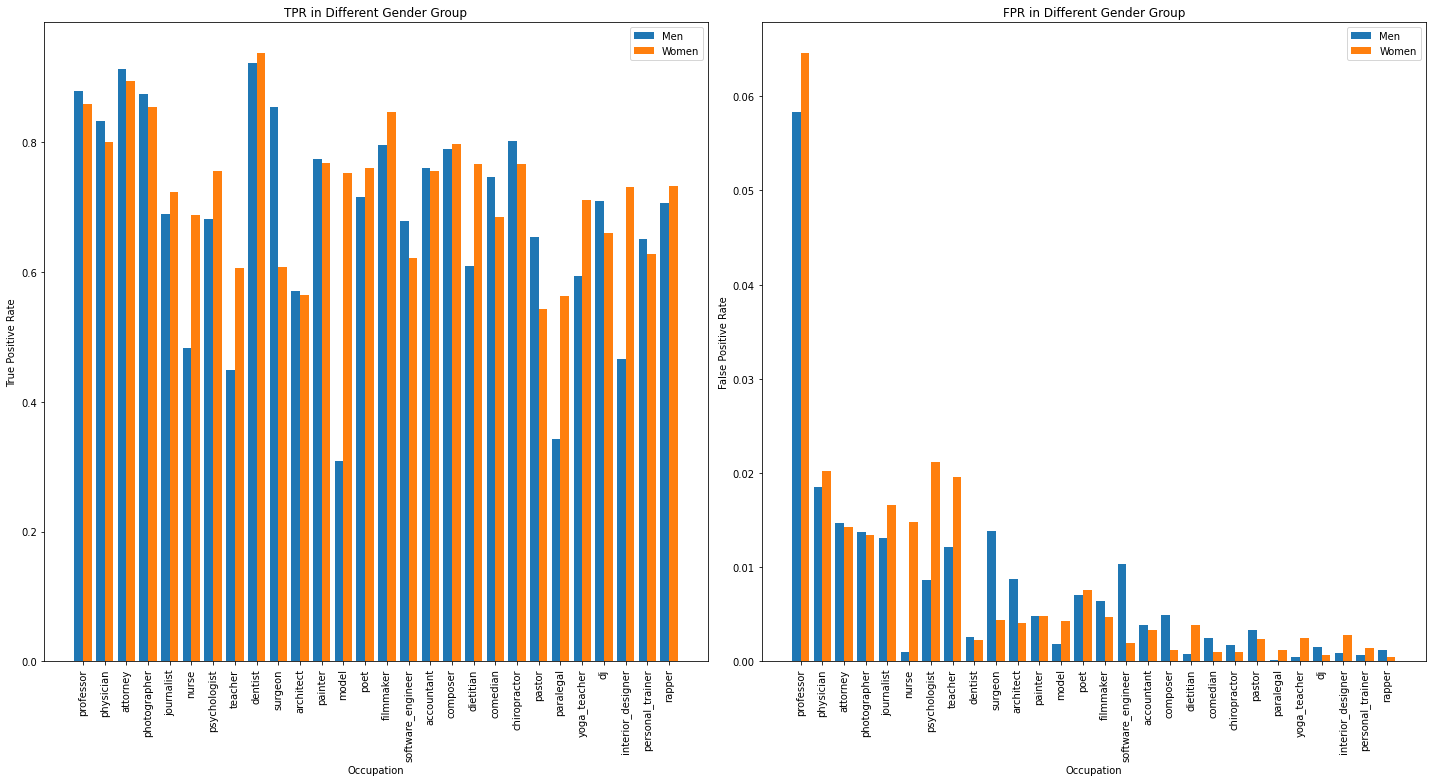

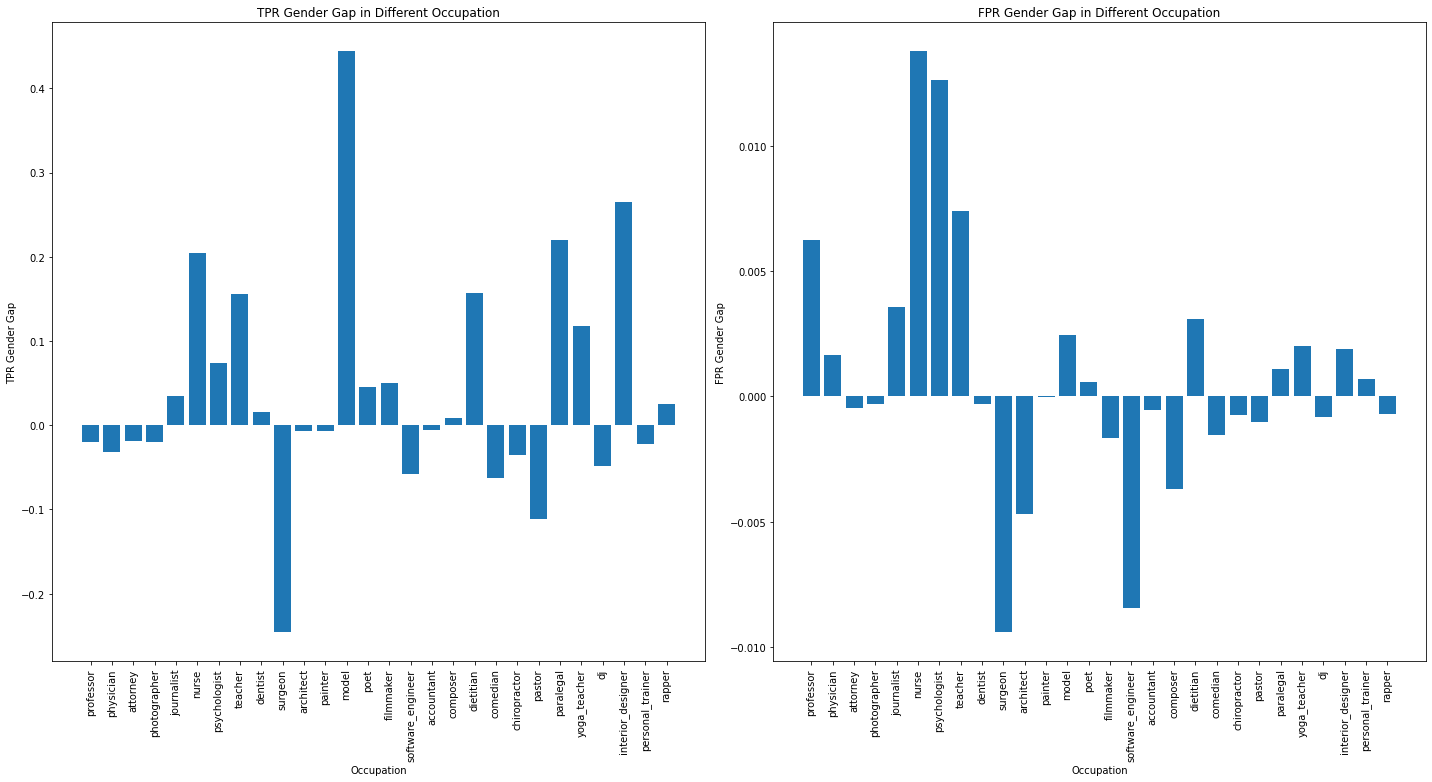

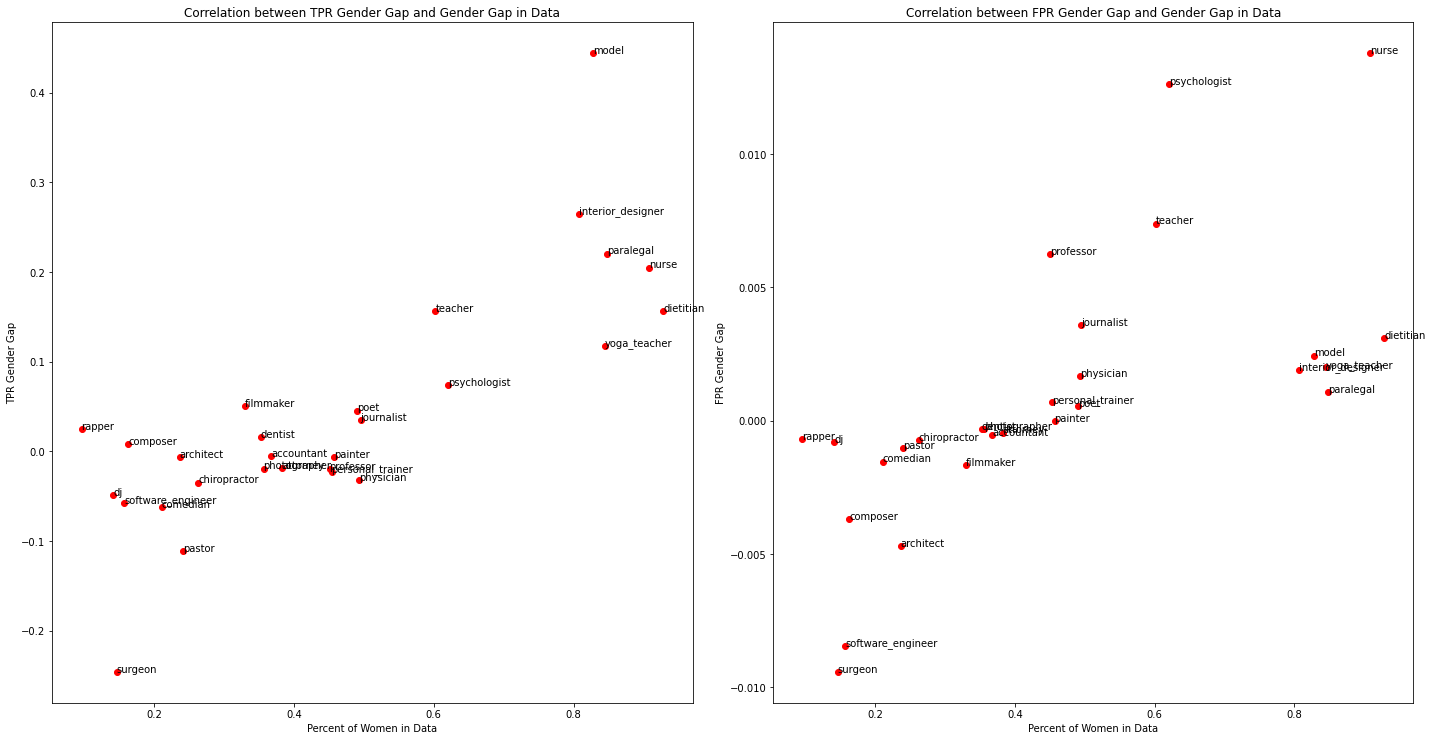

In [99]:
# cnn.pt
cnn_loaded = CNN(PARAMS)
cnn_loaded.load_state_dict(torch.load("cnn.pt"))
cnn_loaded.eval()
print('accuracy:',evaluate(cnn_loaded, test_dataset))
gender_analyze(cnn_loaded,test_m,test_f,target_encoder,per_occ_women,'cnn')

### cnn_flip.pt

accuracy: 0.782750294225072
aTPR: 0.06390665068684213
mTPR: 0.34993217192631726
corr_tpr: 0.16075149825017265
aFPR: 0.0024857410407129283
mFPR: 0.01212841747295722
corr_fpr: 0.055198575310694394


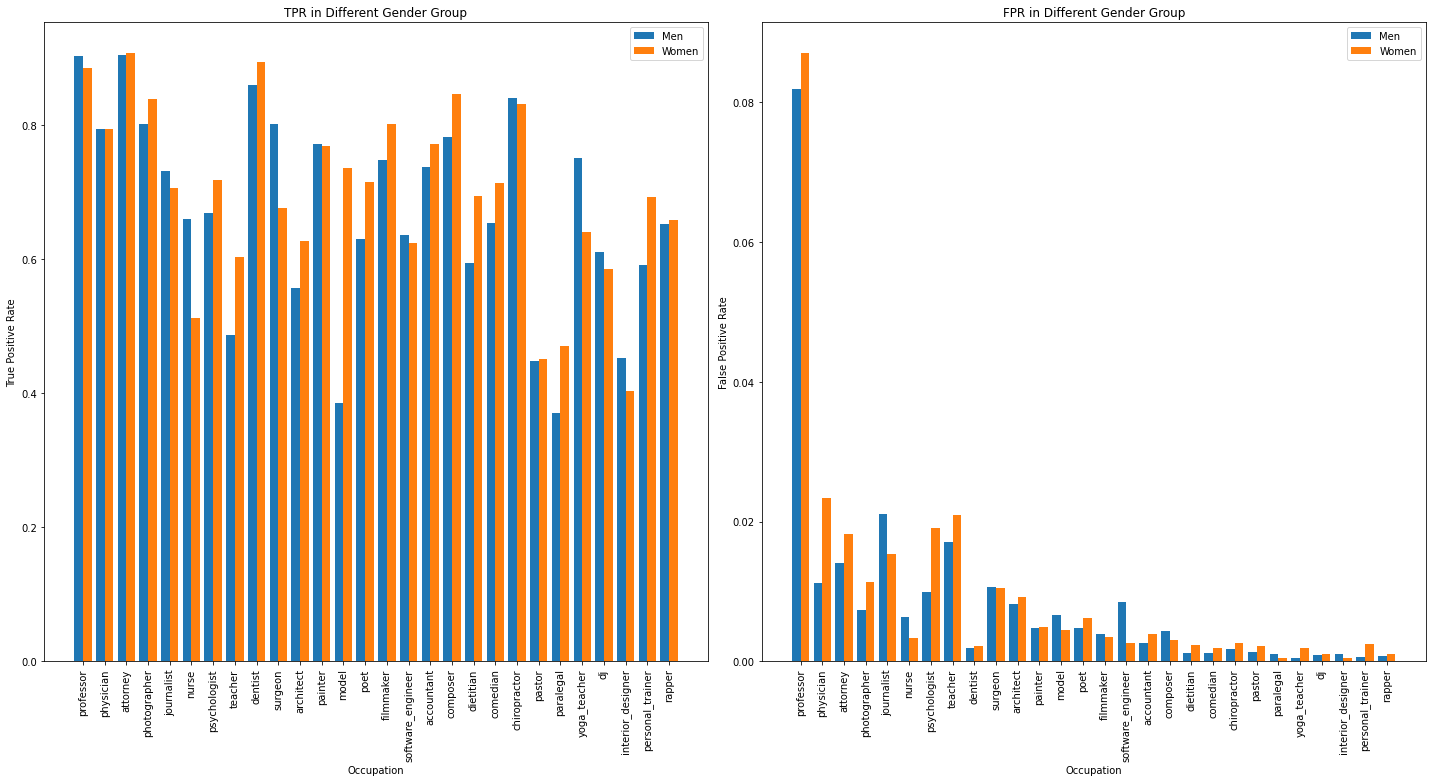

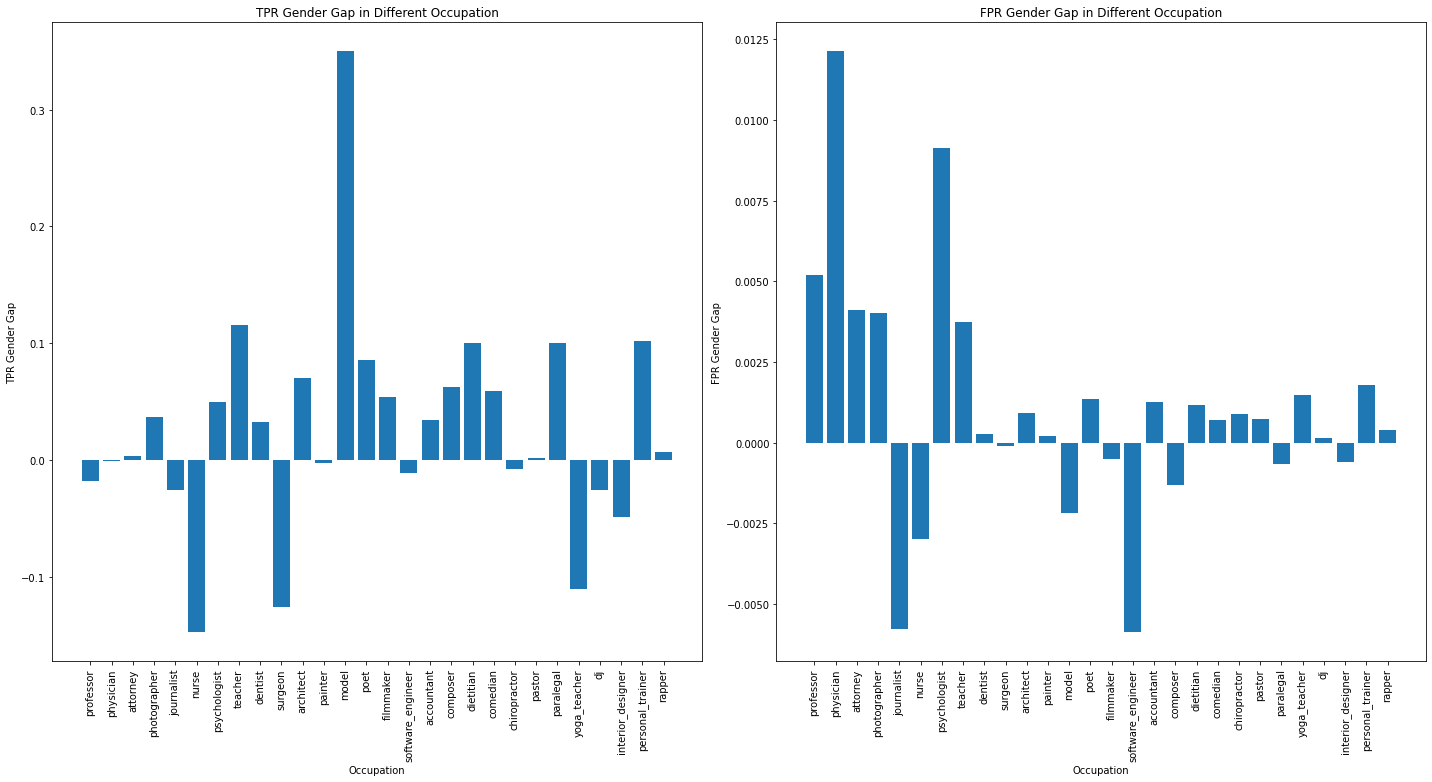

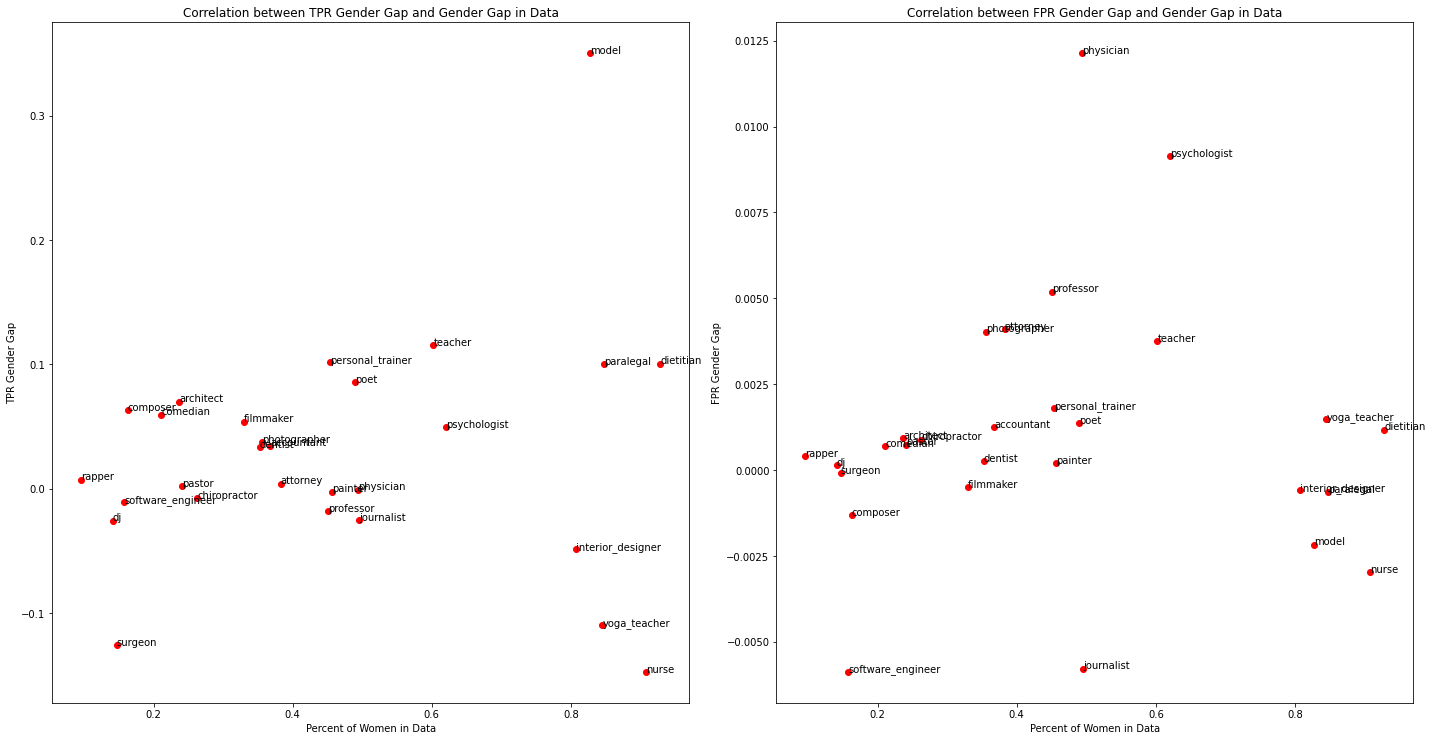

In [100]:
# cnn_flip.pt
cnn_loaded_flip = CNN(PARAMS)
cnn_loaded_flip.load_state_dict(torch.load("cnn_flip.pt"))
cnn_loaded_flip.eval()
print('accuracy:',evaluate(cnn_loaded_flip, test_dataset))
gender_analyze(cnn_loaded_flip,test_m,test_f,target_encoder,per_occ_women,'cnn_flip')

### cnn_up.pt

accuracy: 0.7797674607361714
aTPR: 0.06420187060607135
mTPR: 0.39114308153648436
corr_tpr: 0.6704318651528605
aFPR: 0.002608770165970613
mFPR: 0.010737357037189945
corr_fpr: 0.5800678117610332


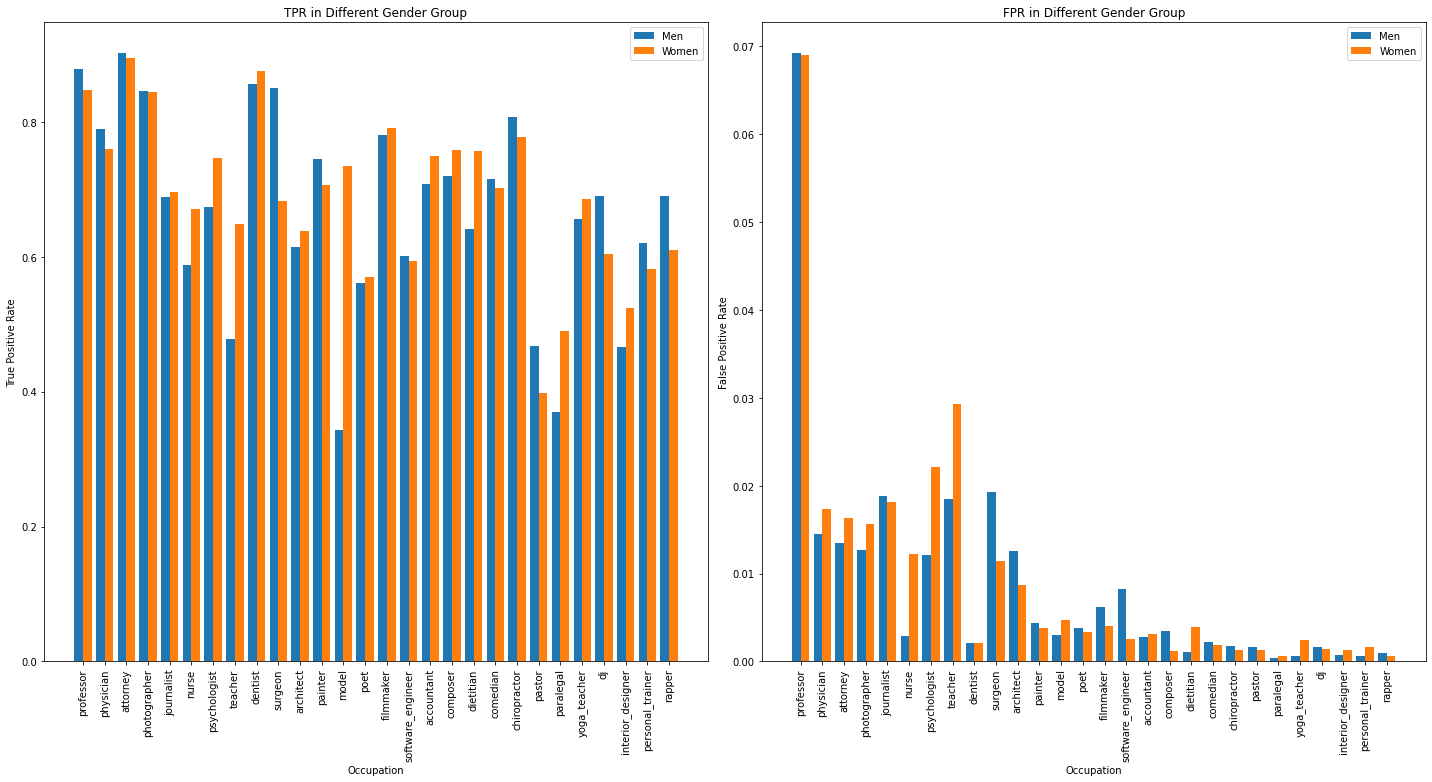

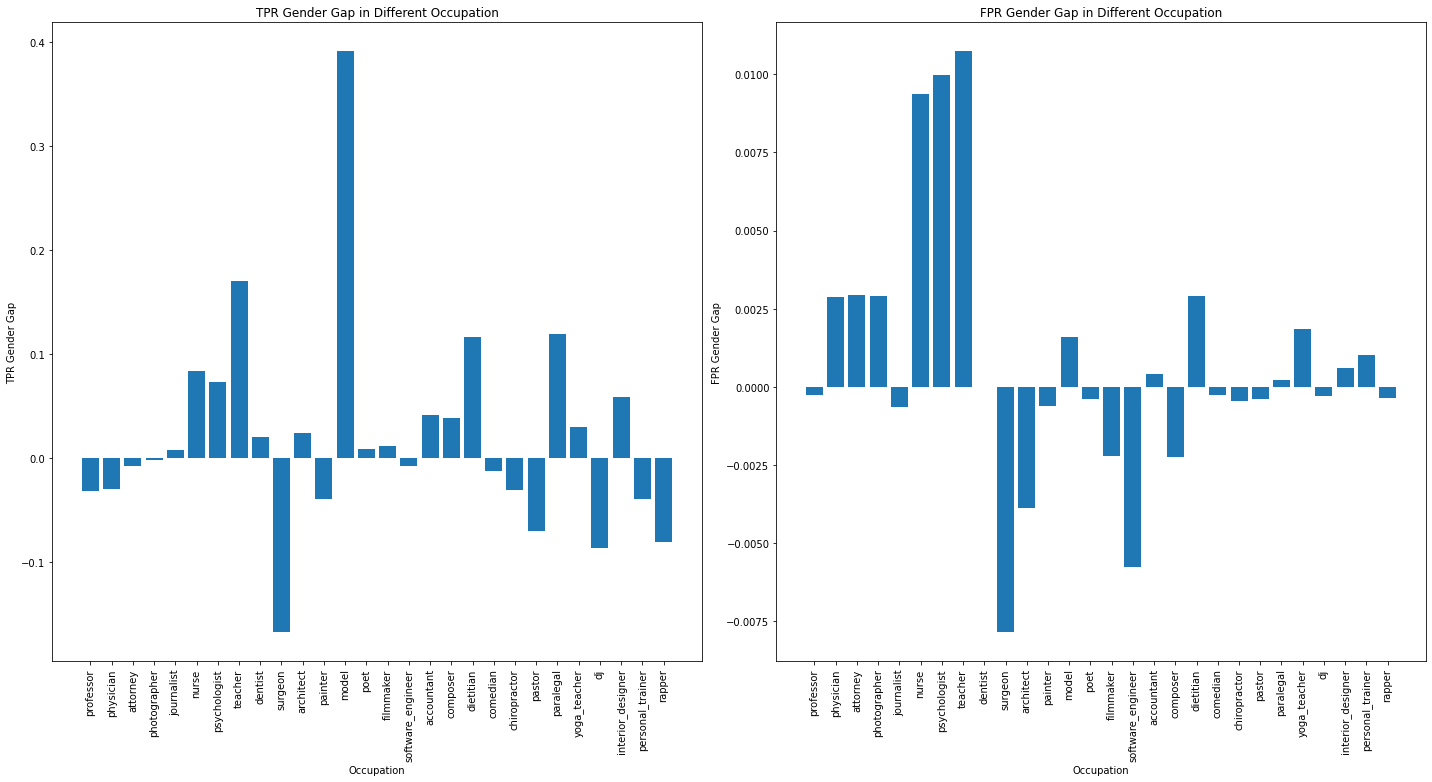

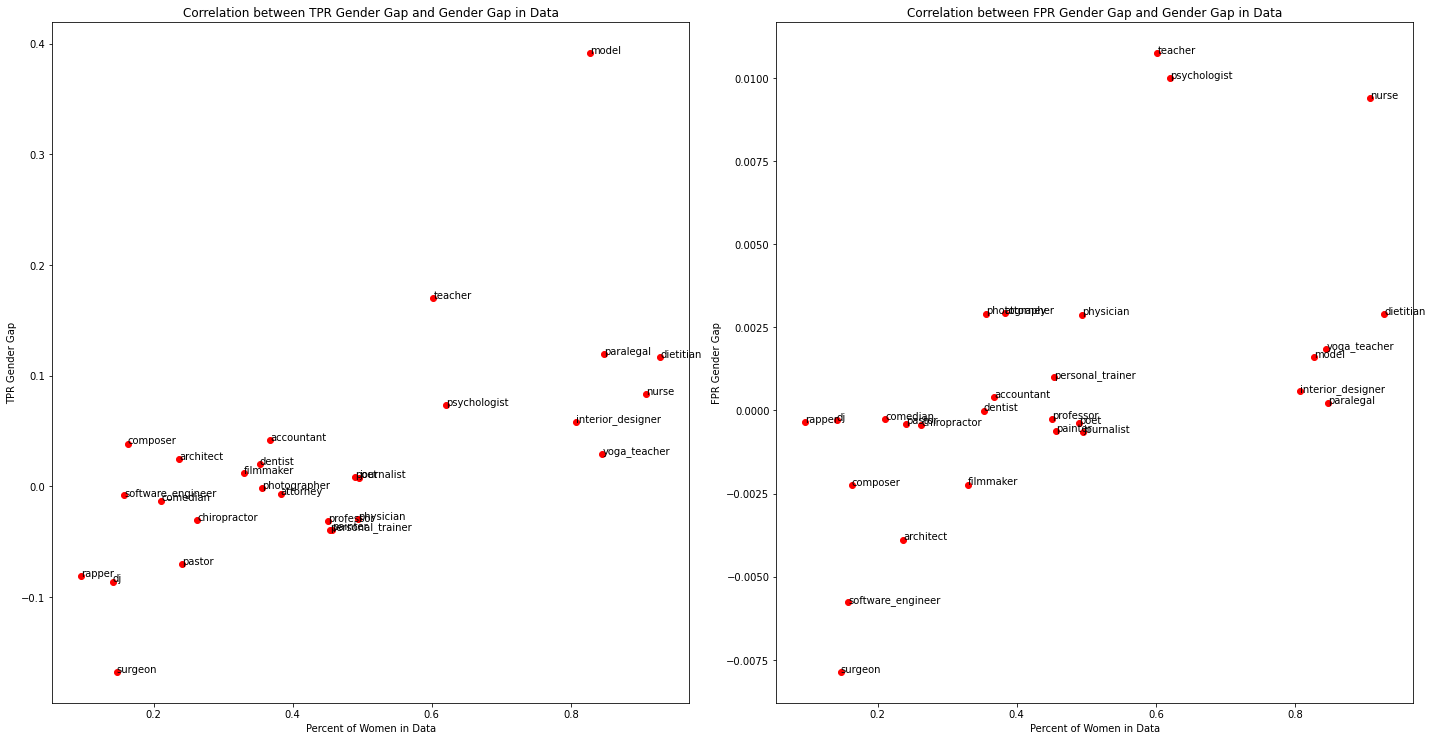

In [101]:
# cnn_up.pt
cnn_loaded_up = CNN(PARAMS)
cnn_loaded_up.load_state_dict(torch.load("cnn_up.pt"))
cnn_loaded_up.eval()
print('accuracy:',evaluate(cnn_loaded_up, test_dataset))
gender_analyze(cnn_loaded_up,test_m,test_f,target_encoder,per_occ_women,'cnn_up')

### cnn_bio.pt

accuracy: 0.7822531553102553
aTPR: 0.07557649551641903
mTPR: 0.3746180208482079
corr_tpr: 0.7515976411829963
aFPR: 0.0030882814408190002
mFPR: 0.011649493039539788
corr_fpr: 0.494131440744813


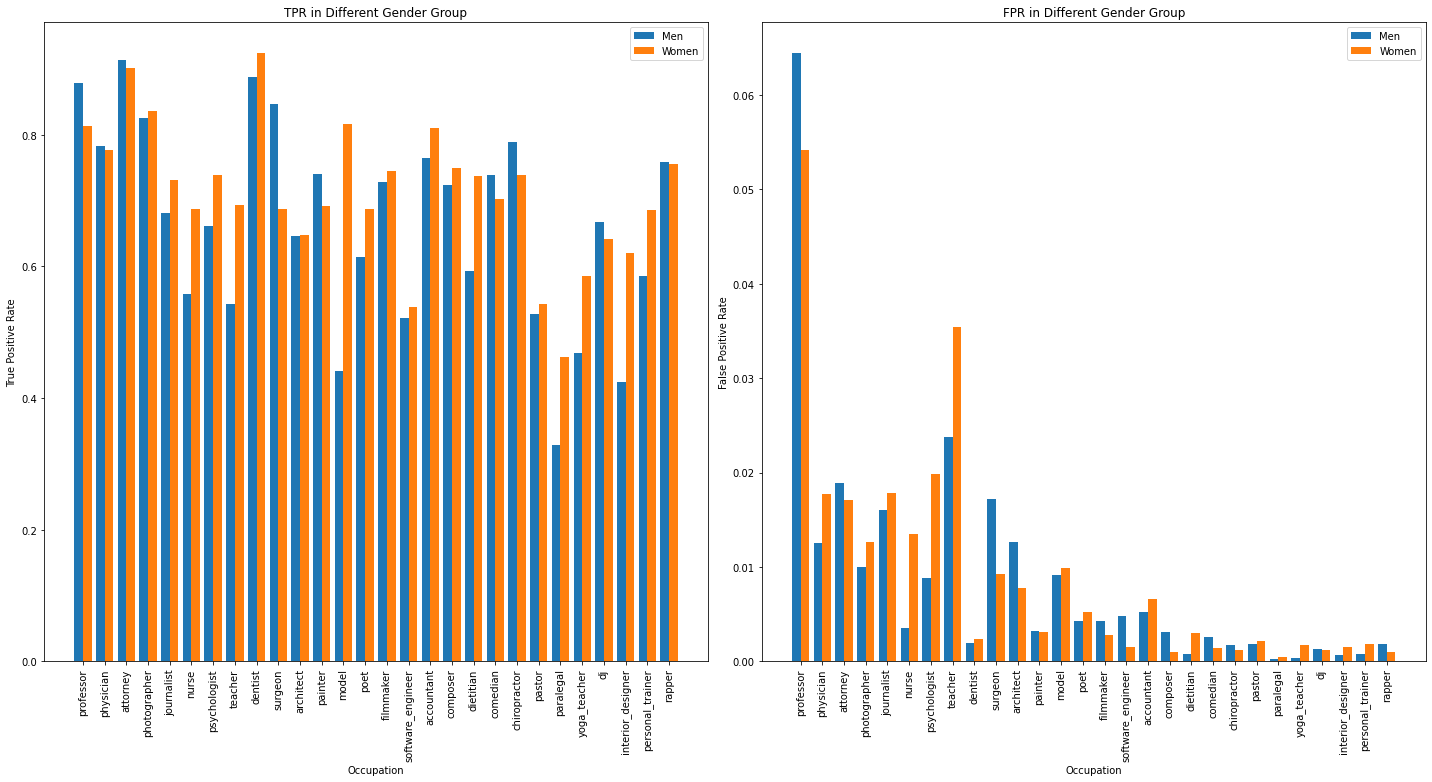

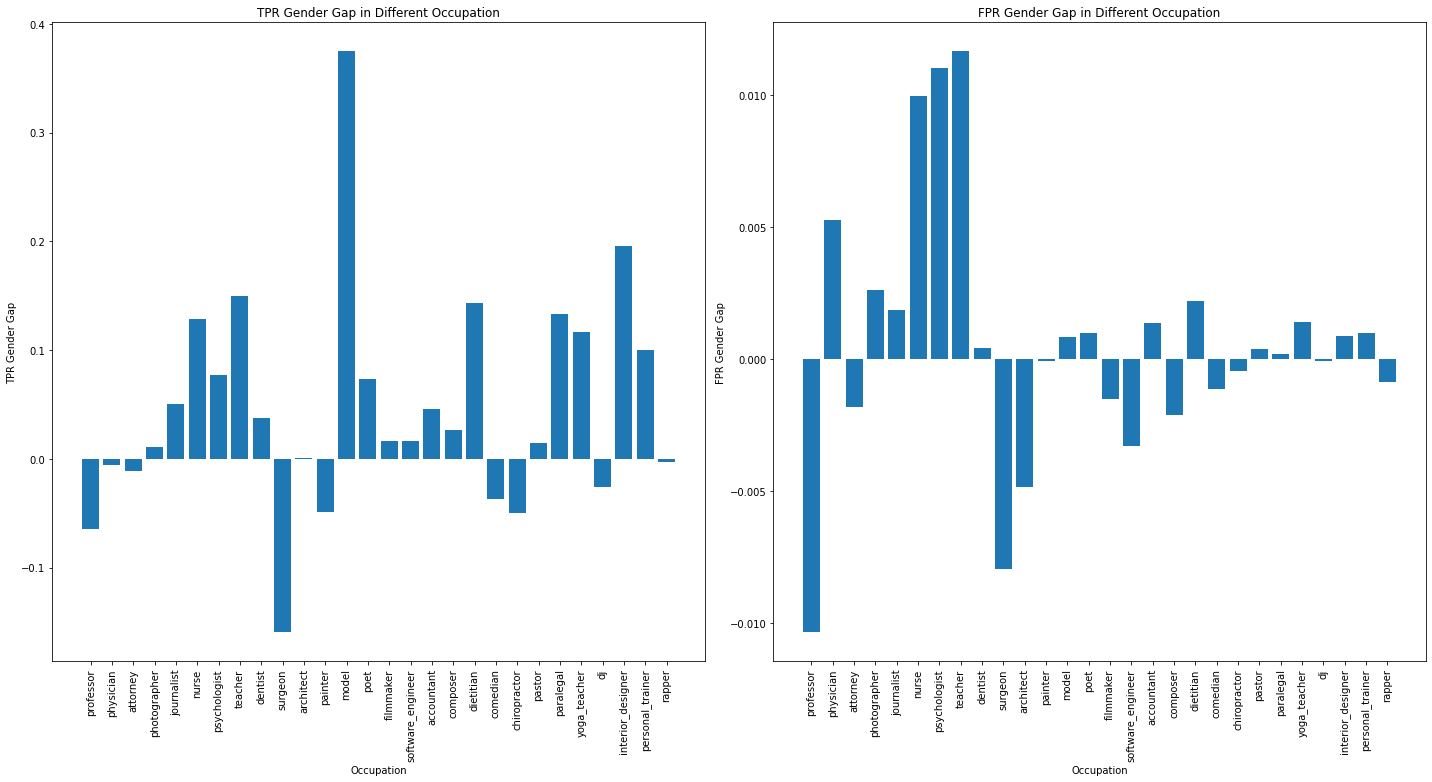

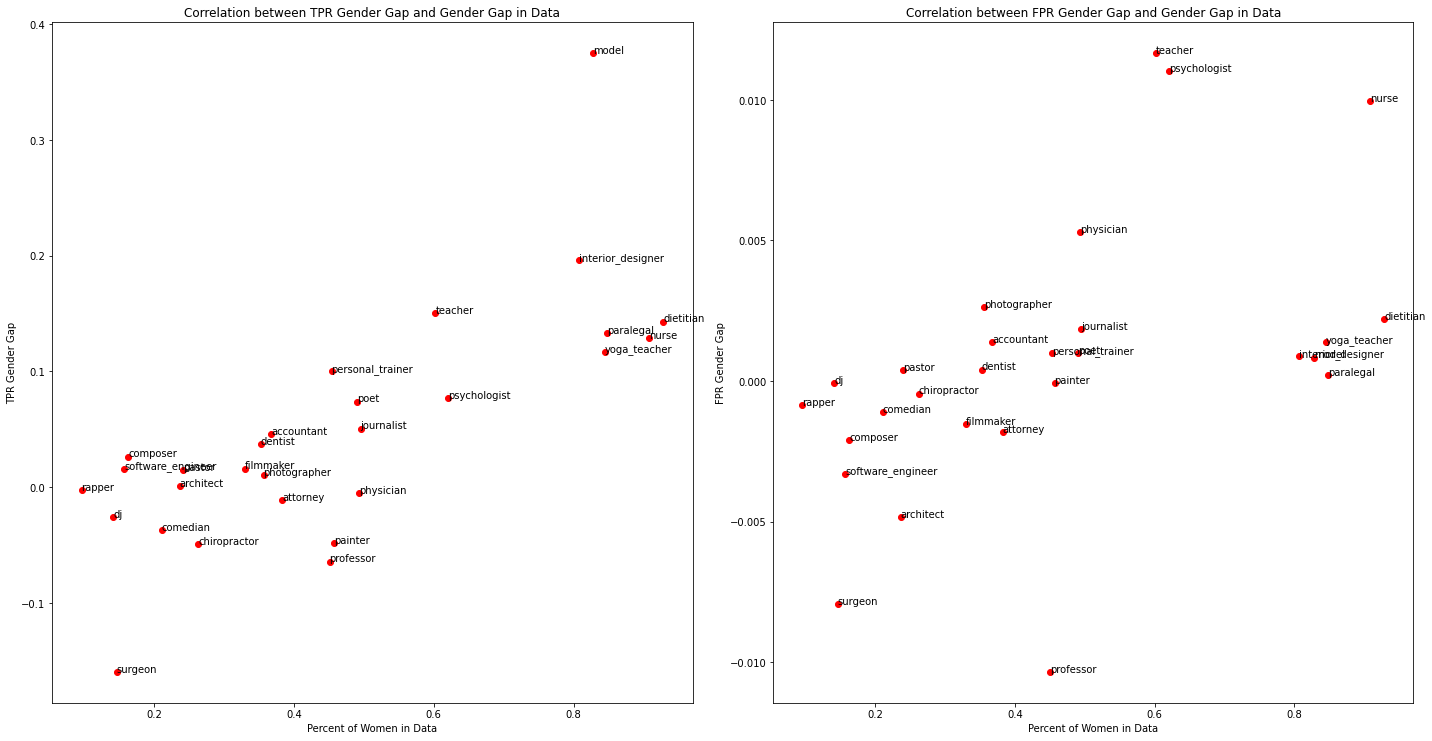

In [102]:
# cnn_bio.pt
cnn_loaded_bio = CNN(PARAMS)
cnn_loaded_bio.load_state_dict(torch.load("cnn_bio.pt"))
cnn_loaded_bio.eval()
print('accuracy:',evaluate(cnn_loaded_bio, test_dataset))
gender_analyze(cnn_loaded_bio,test_m,test_f,target_encoder,per_occ_women,'cnn_bio')

### cnn_nopre.pt

accuracy: 0.7894565967290289
aTPR: 0.10348952110351117
mTPR: 0.48847993716978444
corr_tpr: 0.845759326486292
aFPR: 0.0034845686652628617
mFPR: 0.014674918153297203
corr_fpr: 0.6823230179810087


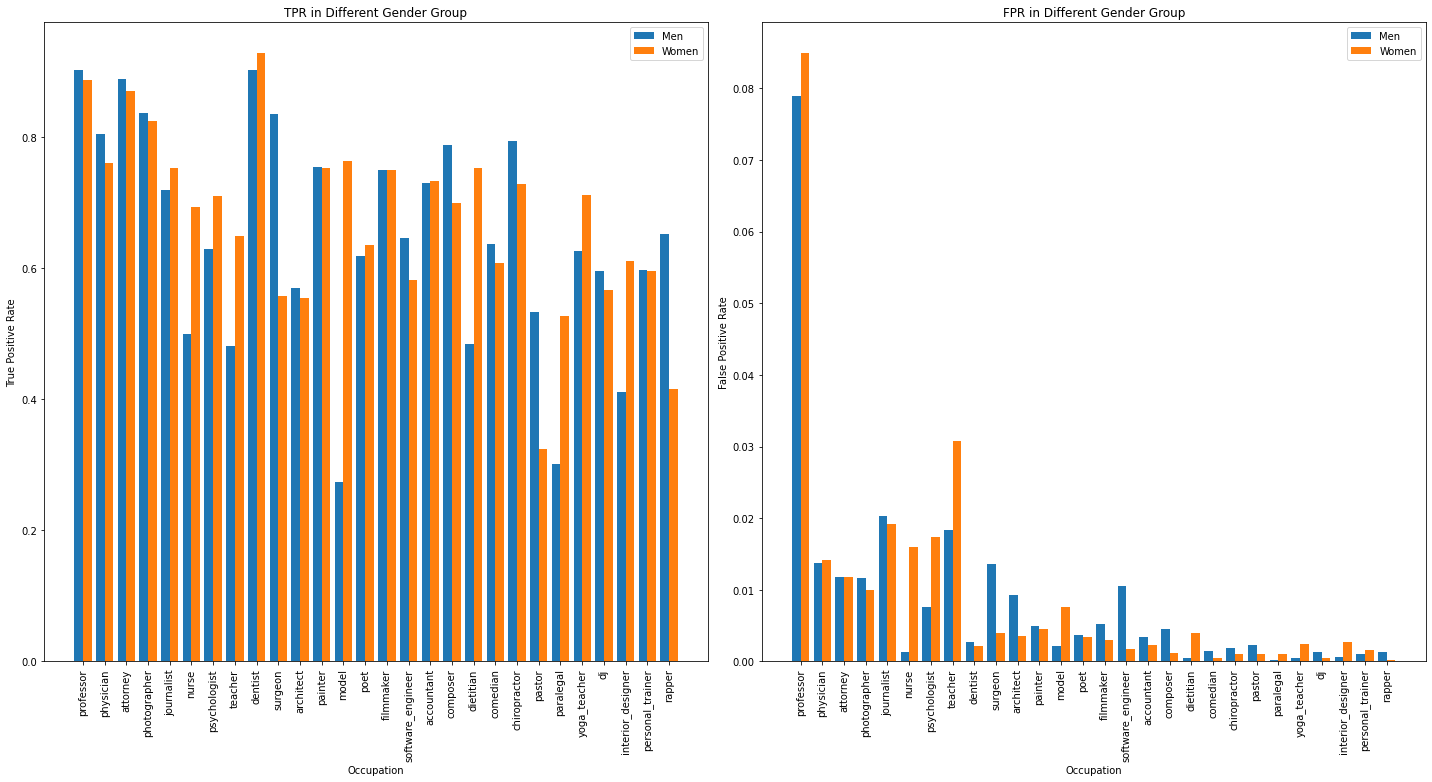

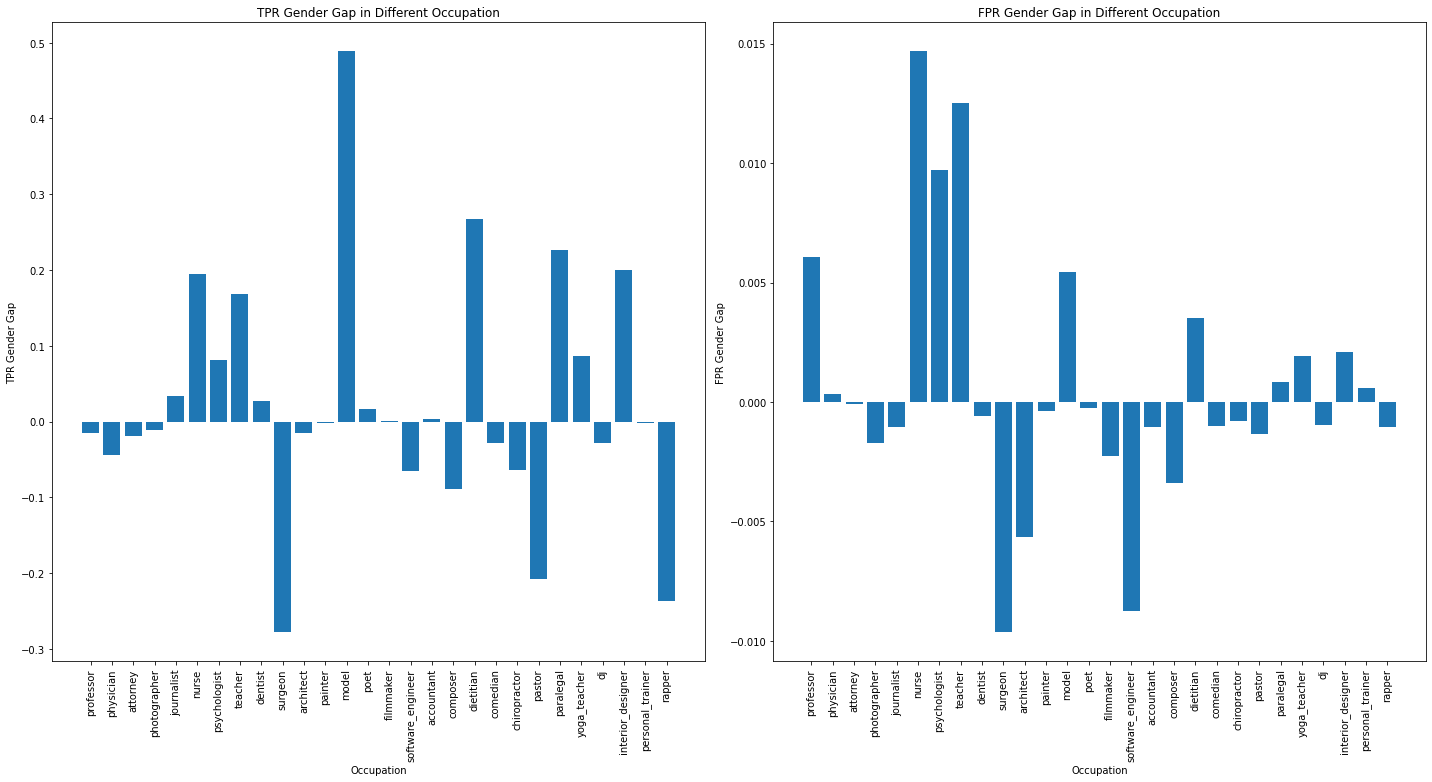

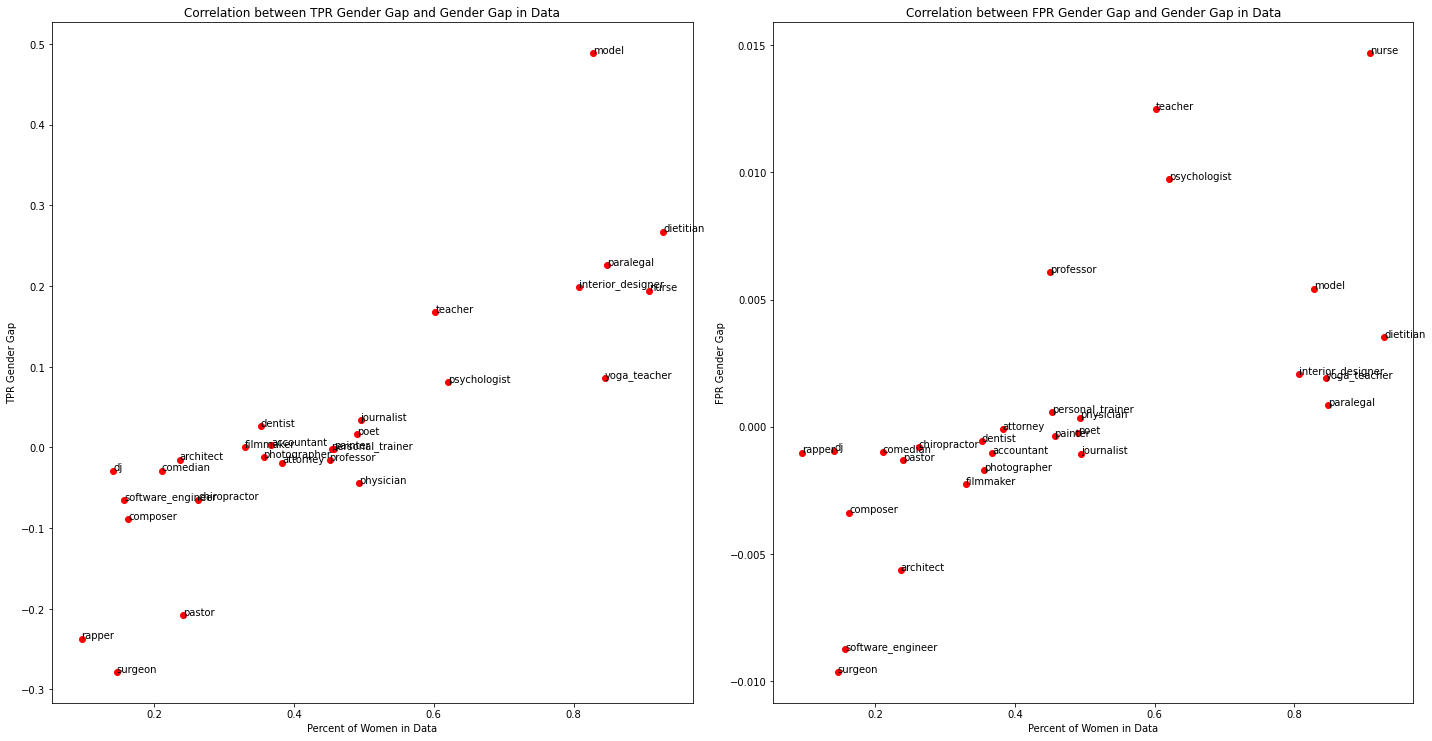

In [103]:
# cnn_nopre.pt
cnn_loaded_nopre = CNN(PARAMS)
cnn_loaded_nopre.load_state_dict(torch.load("cnn_nopre.pt"))
cnn_loaded_nopre.eval()
print('accuracy:',evaluate(cnn_loaded_nopre, test_dataset))
gender_analyze(cnn_loaded_nopre,test_m,test_f,target_encoder,per_occ_women,'cnn_nopre')

### cnn_sub.pt

accuracy: 0.8279333333333333
aTPR: 0.01013987716443797
mTPR: 0.10314207650273233
corr_tpr: 0.4544092536223042
aFPR: 0.0009193330424352514
mFPR: 0.0063877652698185565
corr_fpr: 0.08766549838005316


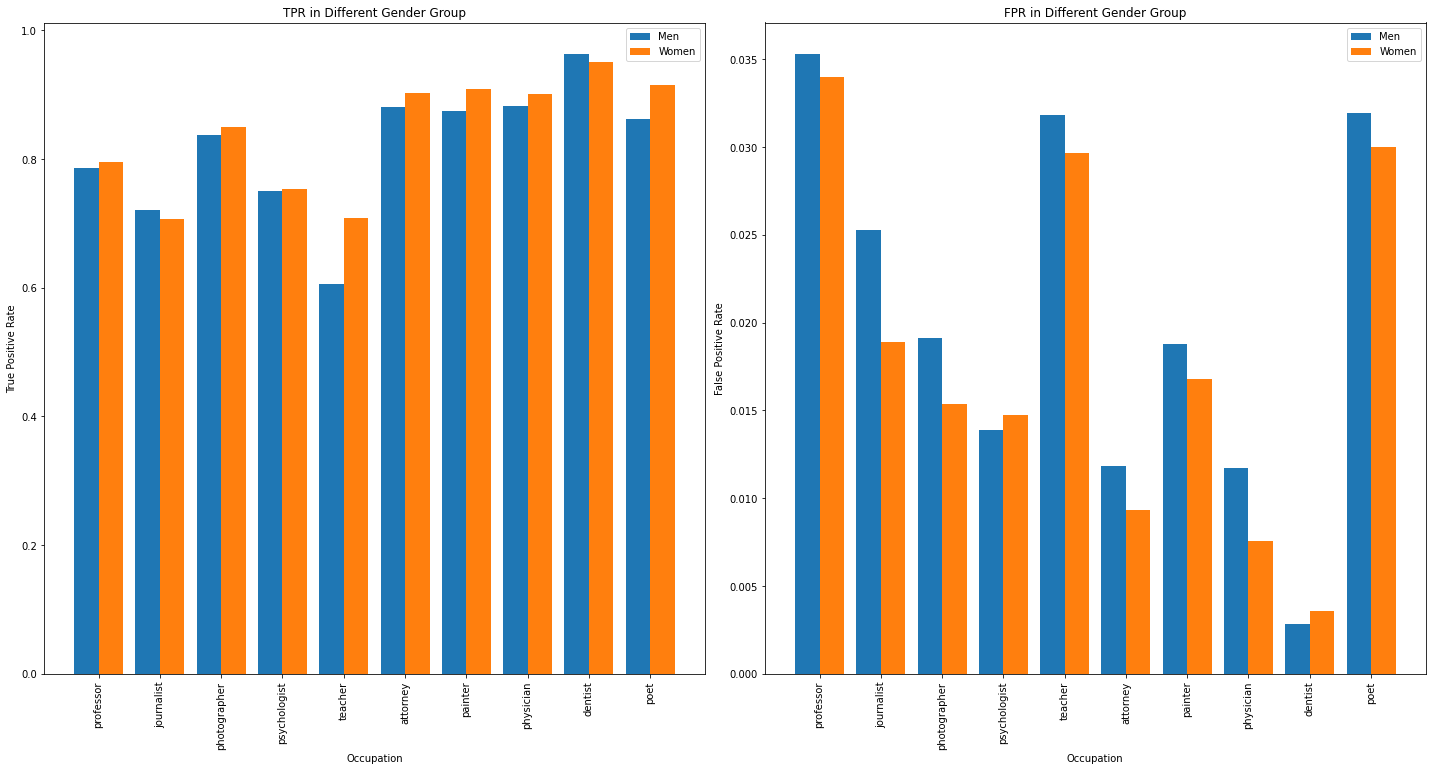

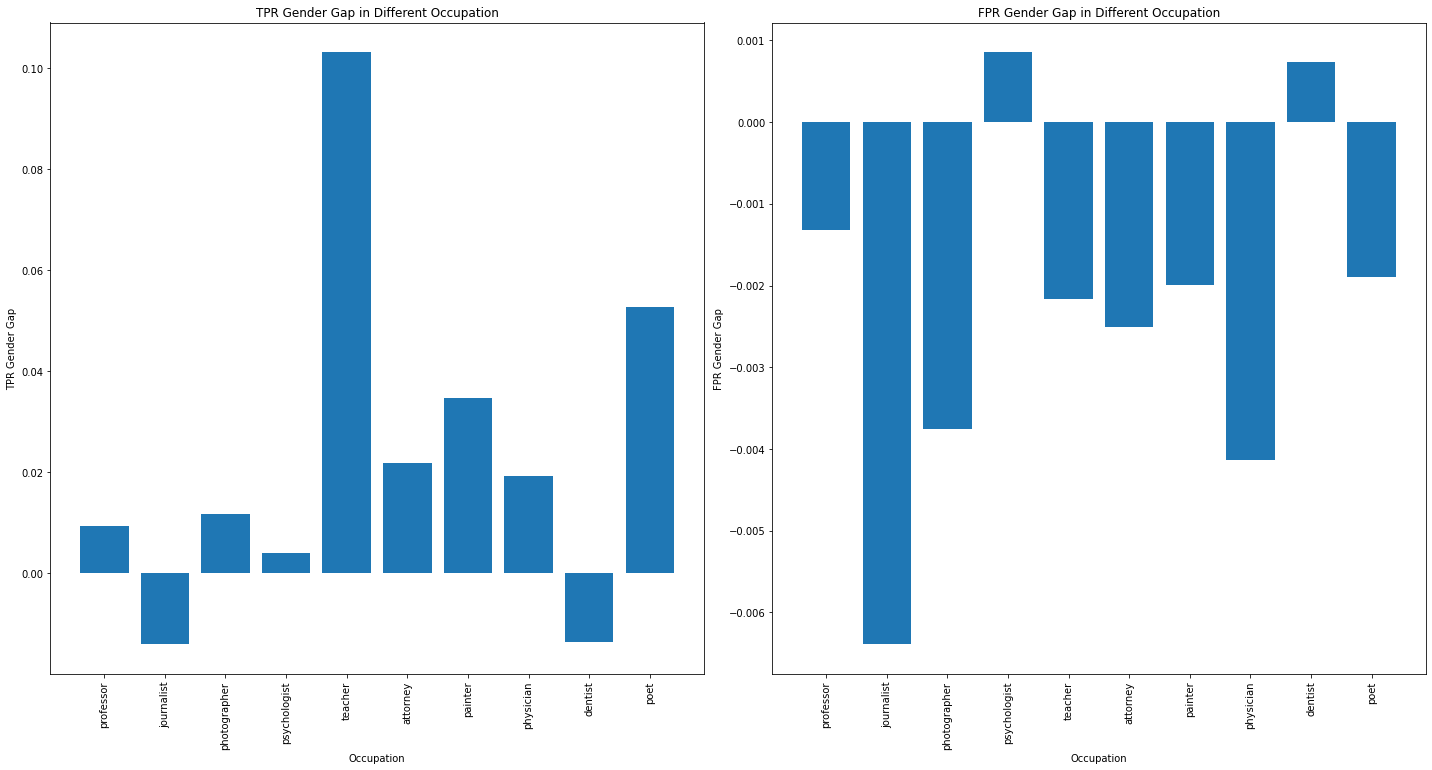

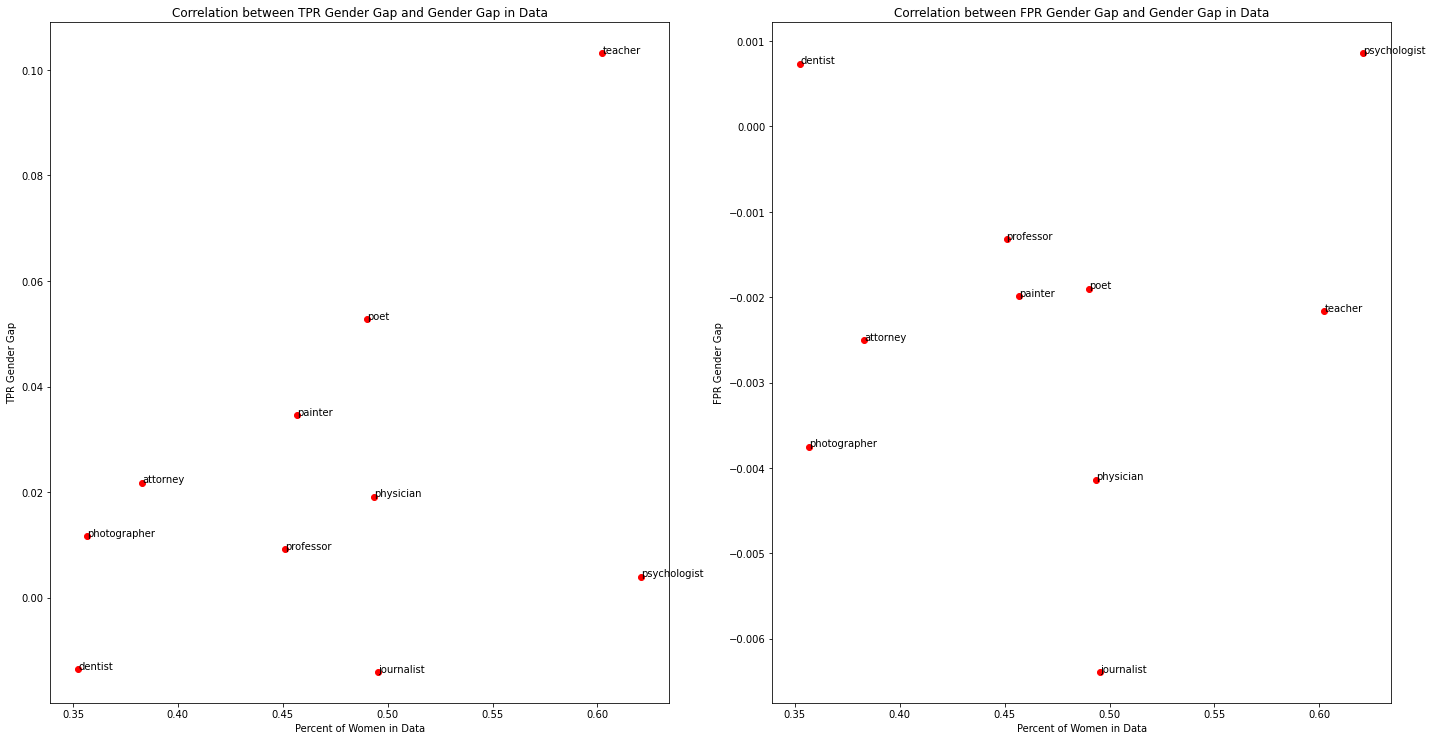

In [104]:
# cnn_sub.pt
cnn_loaded_sub = CNN(SUB_PARAMS)
cnn_loaded_sub.load_state_dict(torch.load("cnn_sub.pt"))
cnn_loaded_sub.eval()
print('accuracy:',evaluate(cnn_loaded_sub, test_dataset_sub))
gender_analyze(cnn_loaded_sub,test_m_sub,test_f_sub,sub_target_encoder,sub_per_occ_women,'cnn_sub')

### LR.pt

accuracy: 0.7912320928533745
aTPR: 0.1269929431472133
mTPR: 0.4971583607025561
corr_tpr: 0.888063713981846
aFPR: 0.0039995940254120305
mFPR: 0.016029841853902594
corr_fpr: 0.6033604381695321


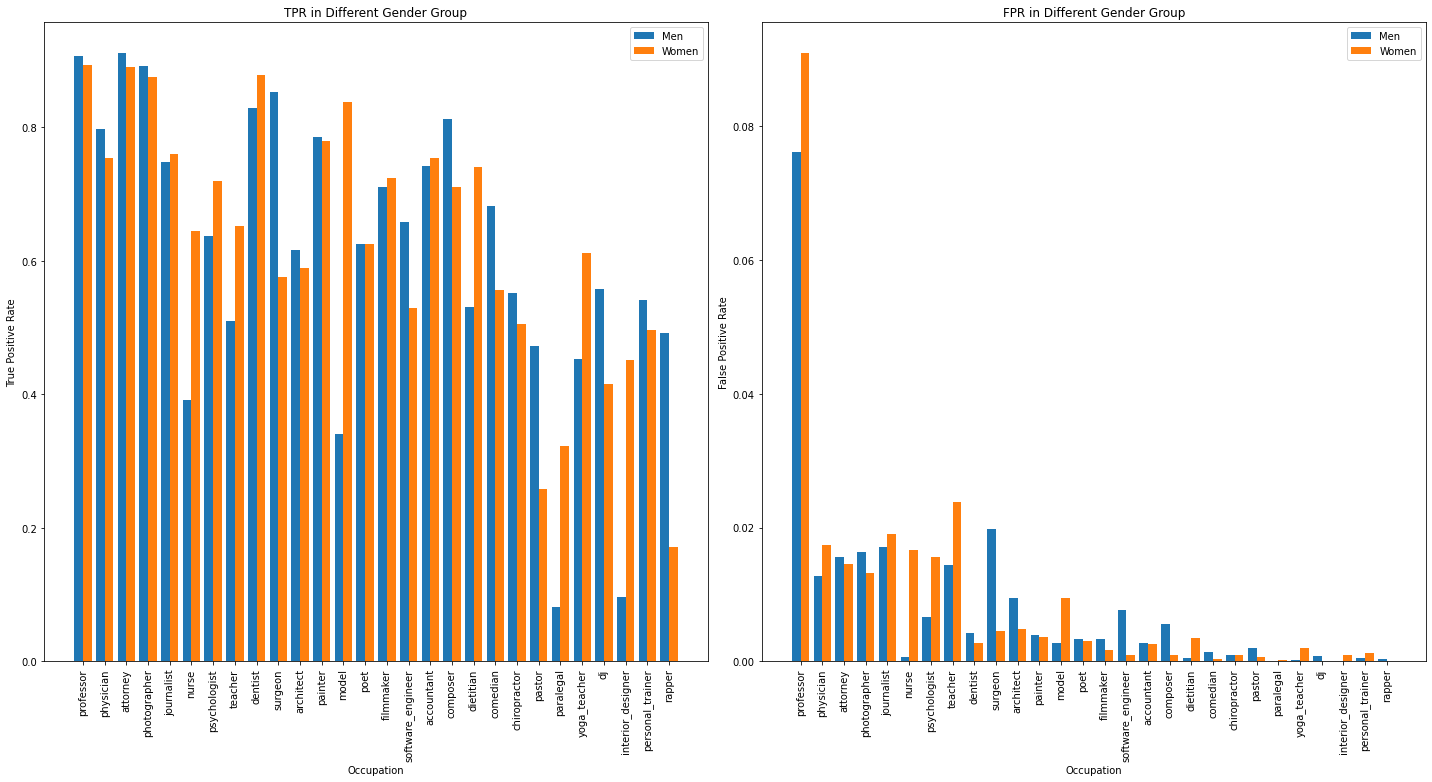

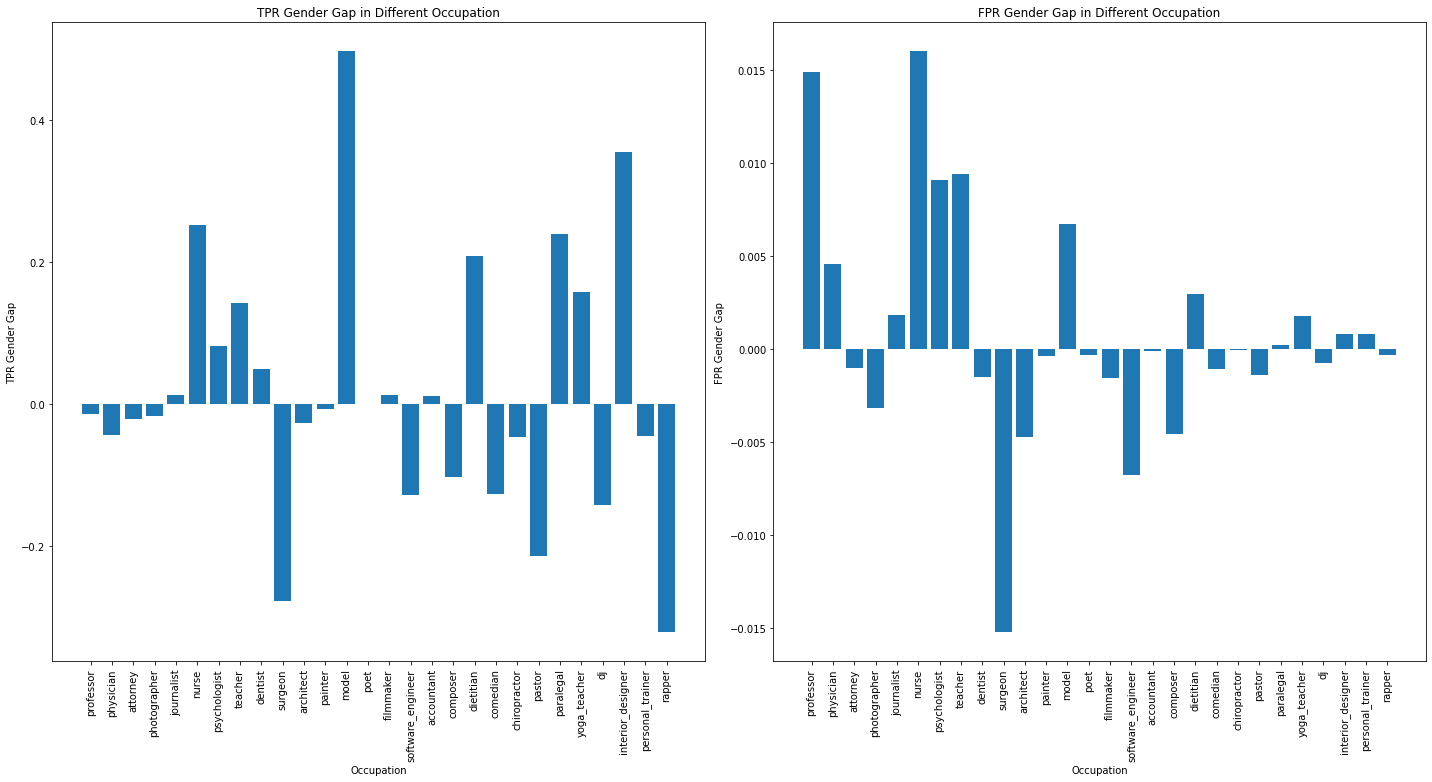

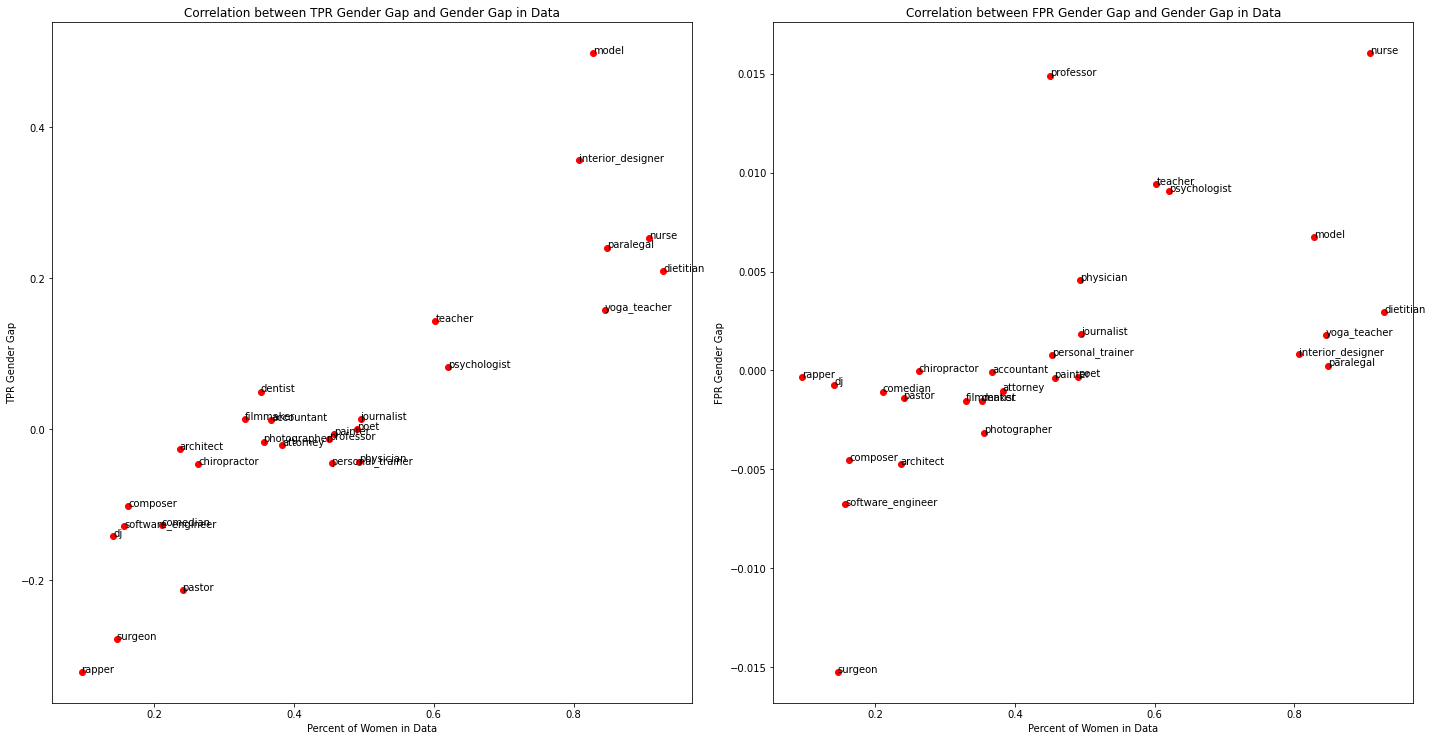

In [105]:
# LR.pt
LR_inst = LR(PARAMS)
LR_inst.load_state_dict(torch.load("LR.pt"))
LR_inst.eval()
print('accuracy:',evaluate(LR_inst.cpu(), test_dataset))
gender_analyze(LR_inst,test_m,test_f,target_encoder,per_occ_women,'LR')

### LR_flip.pt

accuracy: 0.7767744815551317
aTPR: 0.06608683760316546
mTPR: 0.3200307011280879
corr_tpr: -0.10503887009507357
aFPR: 0.003543269939800214
mFPR: 0.019558989927415657
corr_fpr: -0.007976425939823261


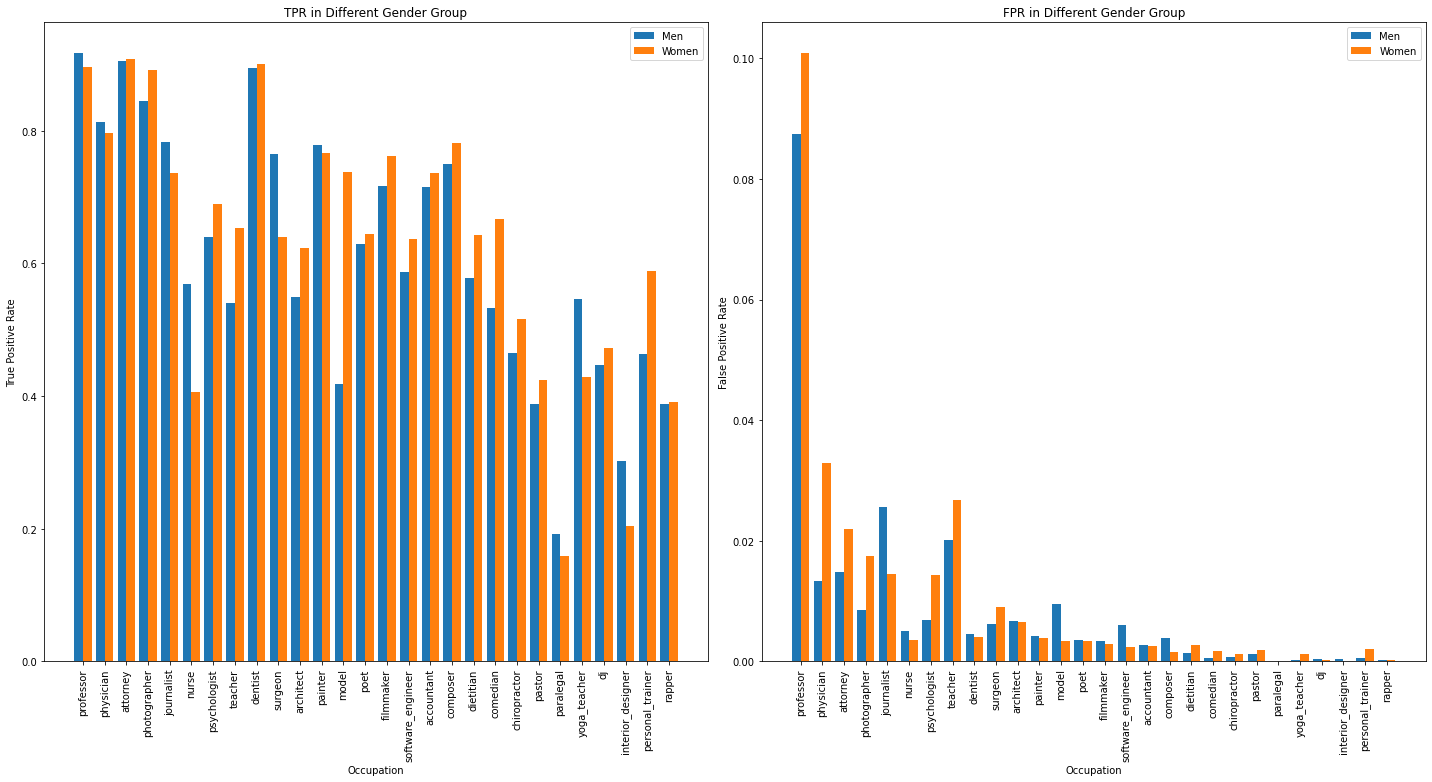

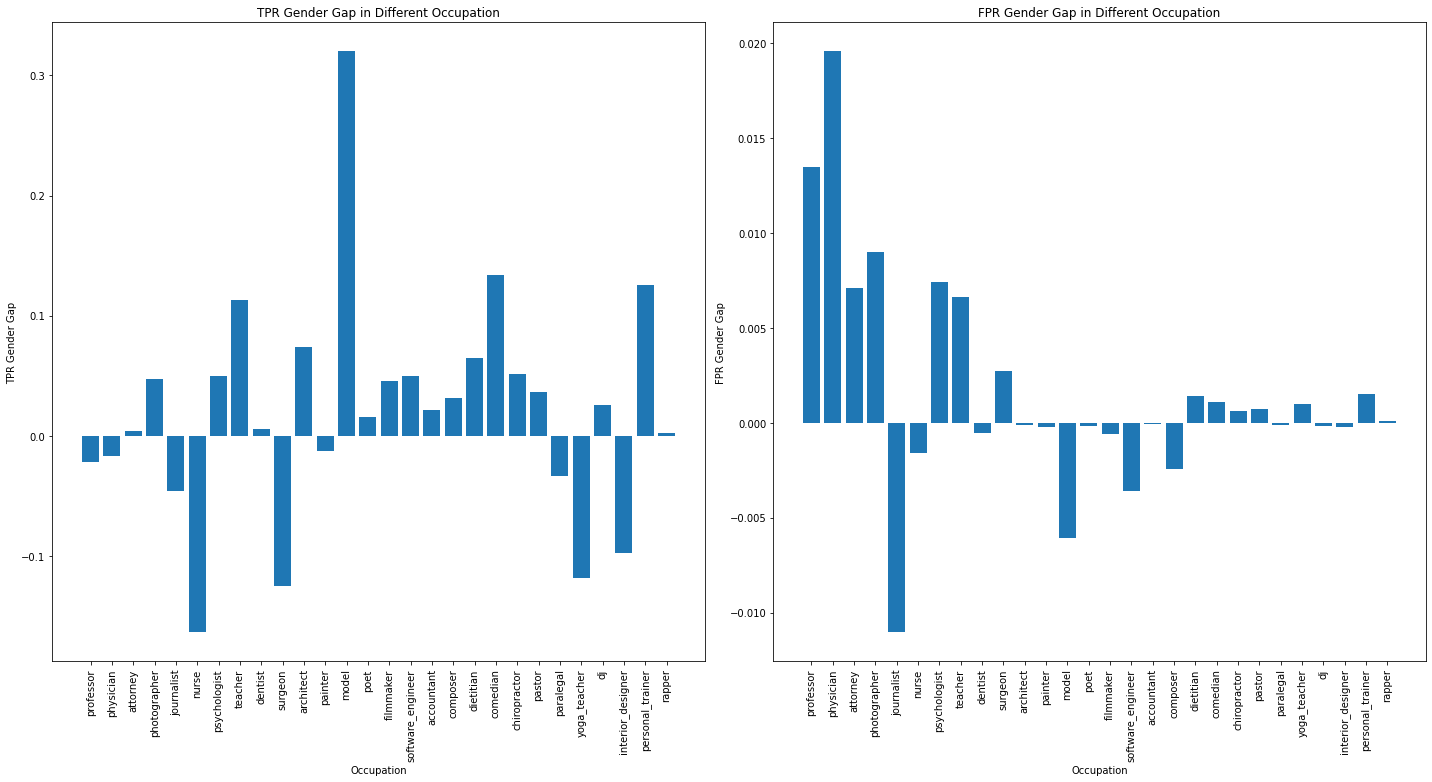

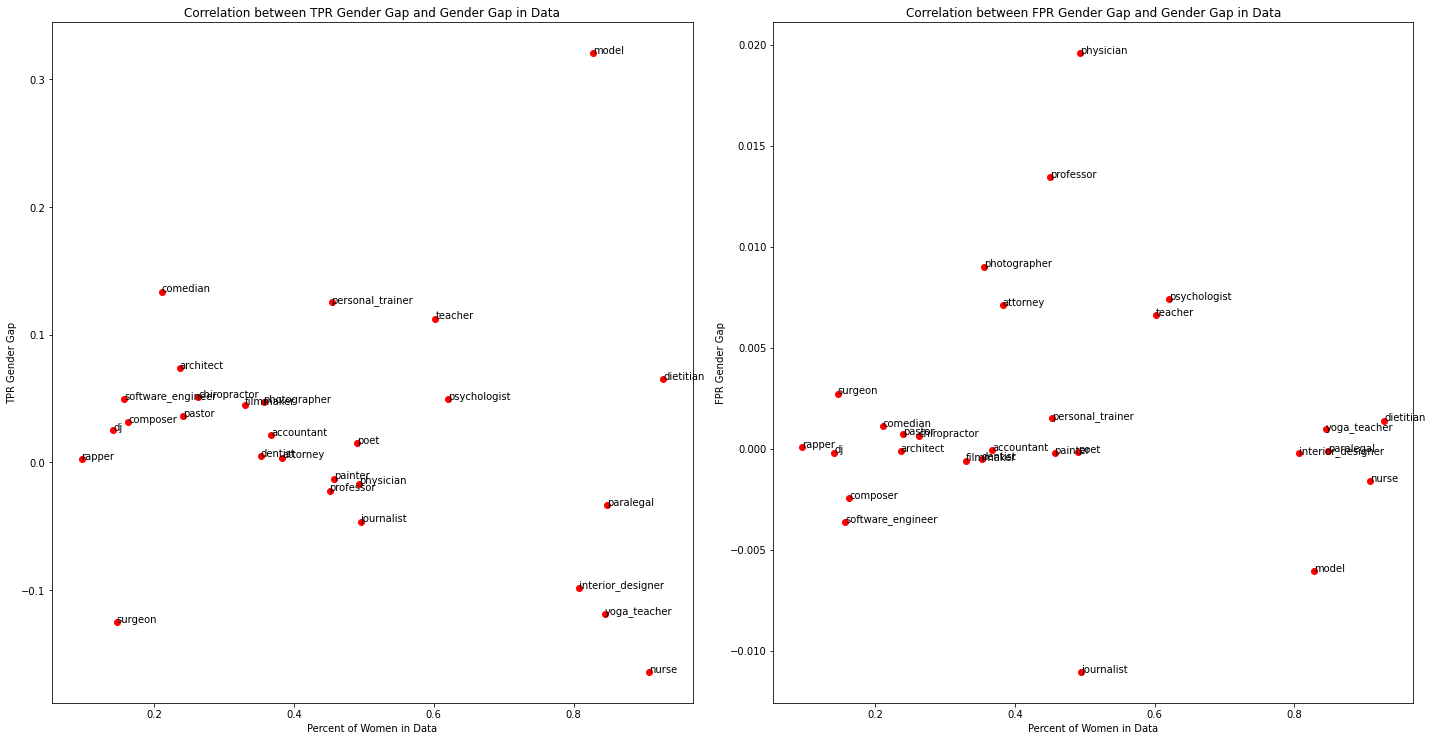

In [106]:
# LR_flip.pt
LR_inst_flip = LR(PARAMS)
LR_inst_flip.load_state_dict(torch.load("LR_flip.pt"))
LR_inst_flip.eval()
print('accuracy:',evaluate(LR_inst_flip.cpu(), test_dataset)) 
gender_analyze(LR_inst_flip,test_m,test_f,target_encoder,per_occ_women,'LR_flip')

### LR_up.pt

accuracy: 0.7922872448358427
aTPR: 0.060893298961181085
mTPR: 0.31009210338426396
corr_tpr: 0.5465788760684095
aFPR: 0.0024079249736410862
mFPR: 0.013547534674063583
corr_fpr: 0.45572345918241564


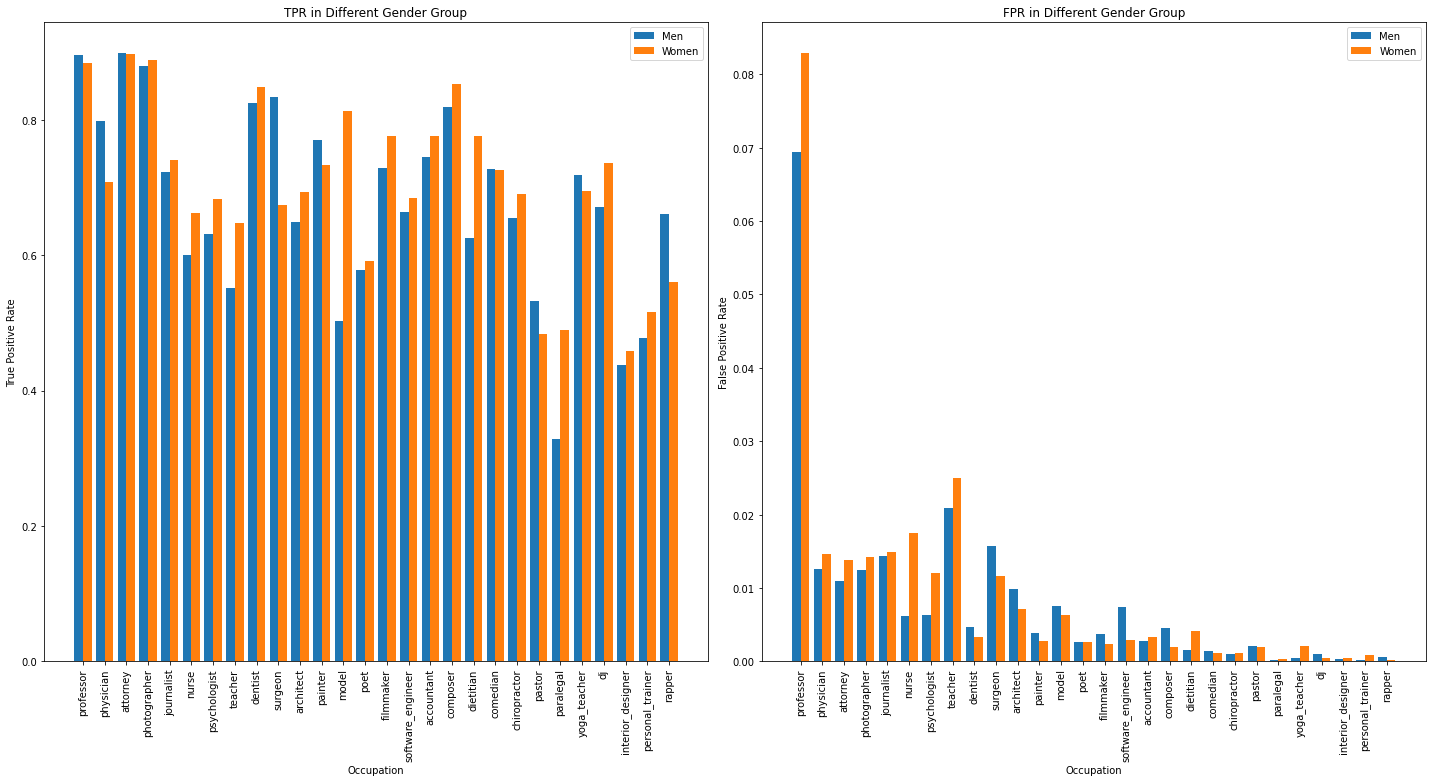

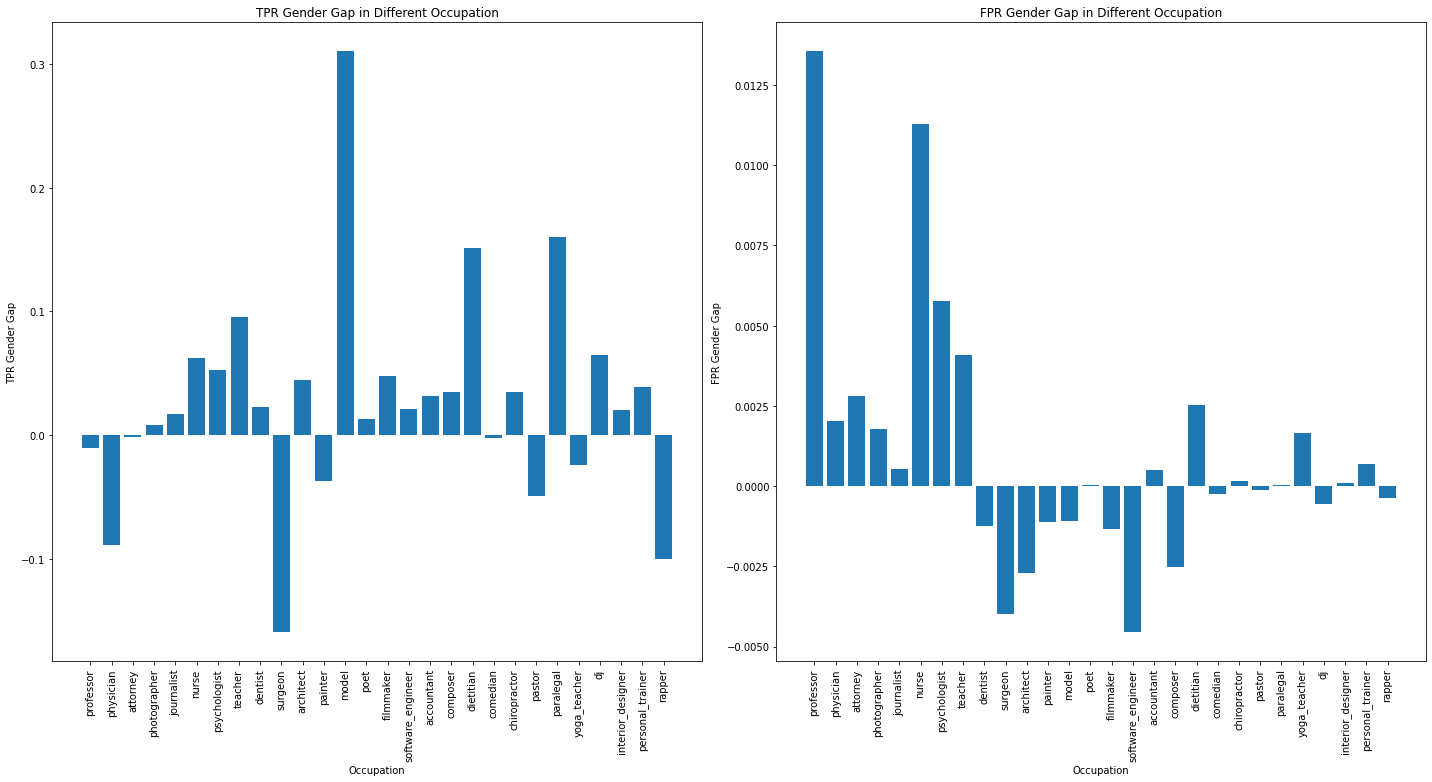

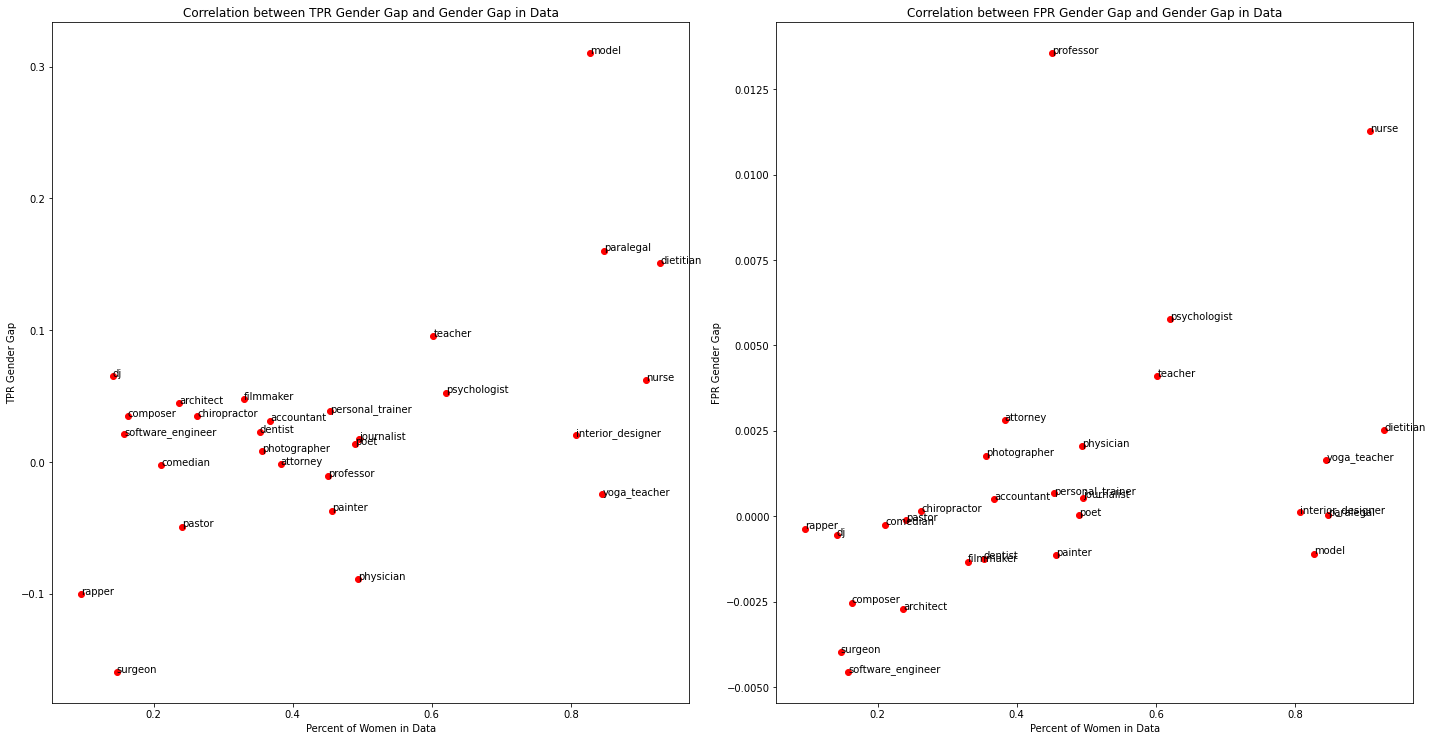

In [107]:
# LR_up.pt
LR_inst_up = LR(PARAMS)
LR_inst_up.load_state_dict(torch.load("LR_up.pt"))
LR_inst_up.eval()
print('accuracy:',evaluate(LR_inst_up.cpu(), test_dataset)) 
gender_analyze(LR_inst_up,test_m,test_f,target_encoder,per_occ_women,'LR_up')

### LR_bio.pt

accuracy: 0.7856113794083033
aTPR: 0.0747099199215482
mTPR: 0.395619734399543
corr_tpr: 0.7476526179428246
aFPR: 0.0029086632161339056
mFPR: 0.01201453232624441
corr_fpr: 0.5288339078580201


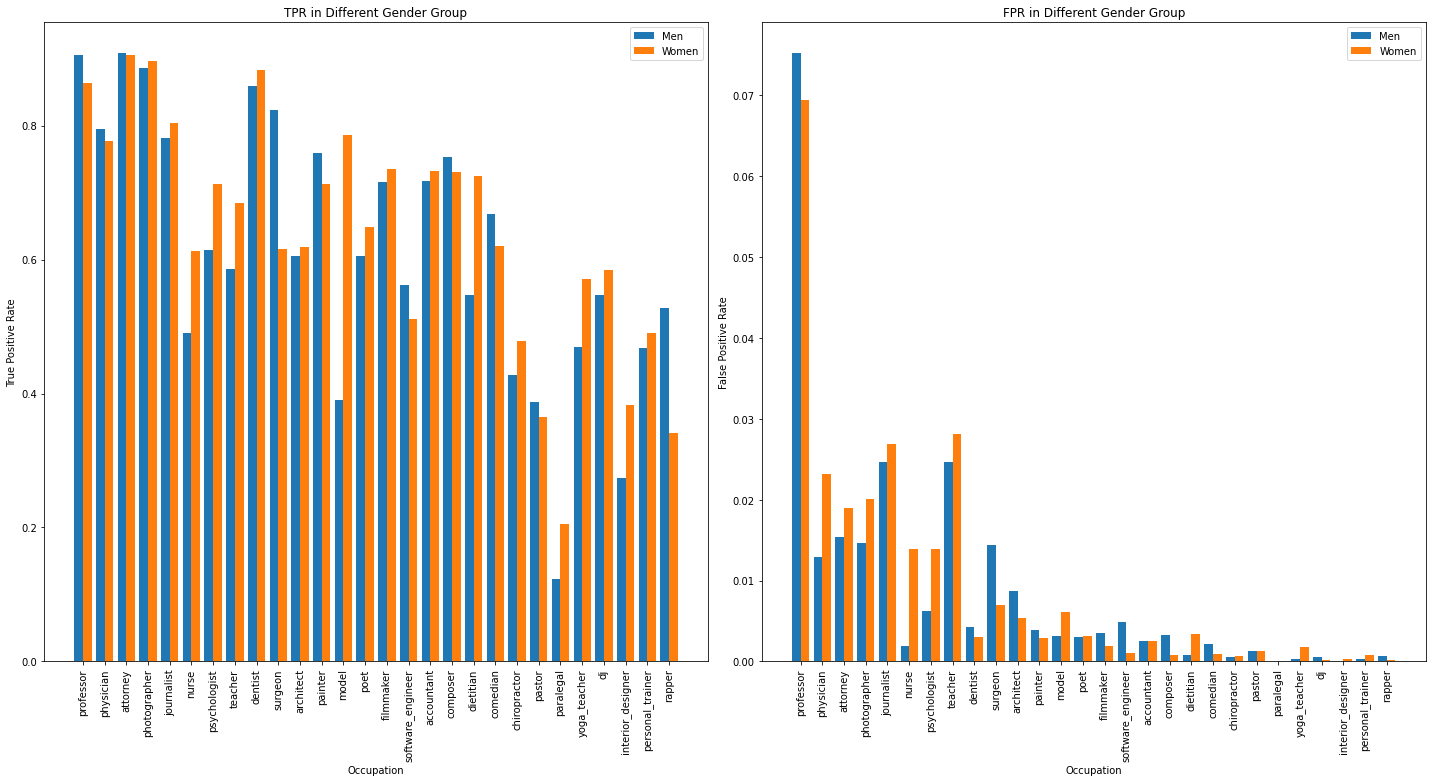

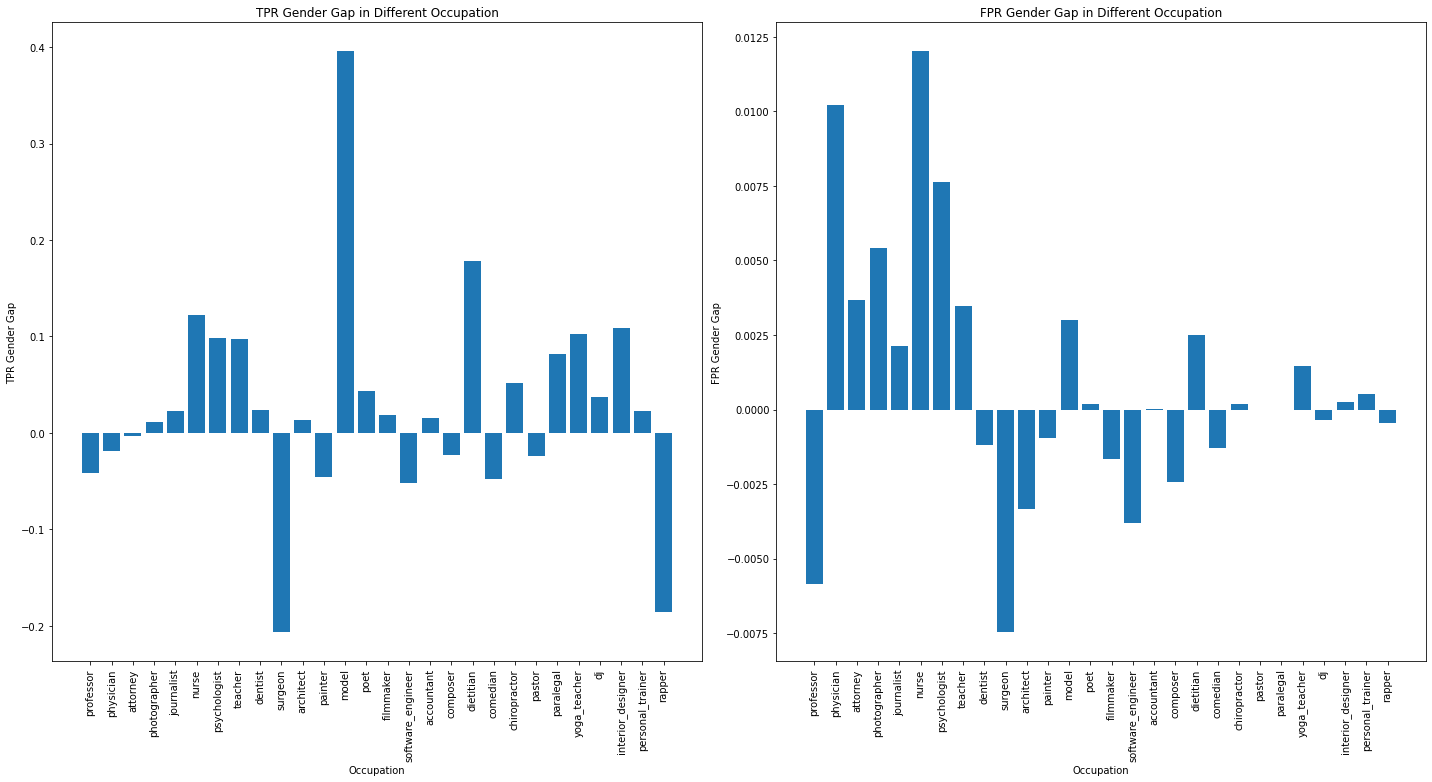

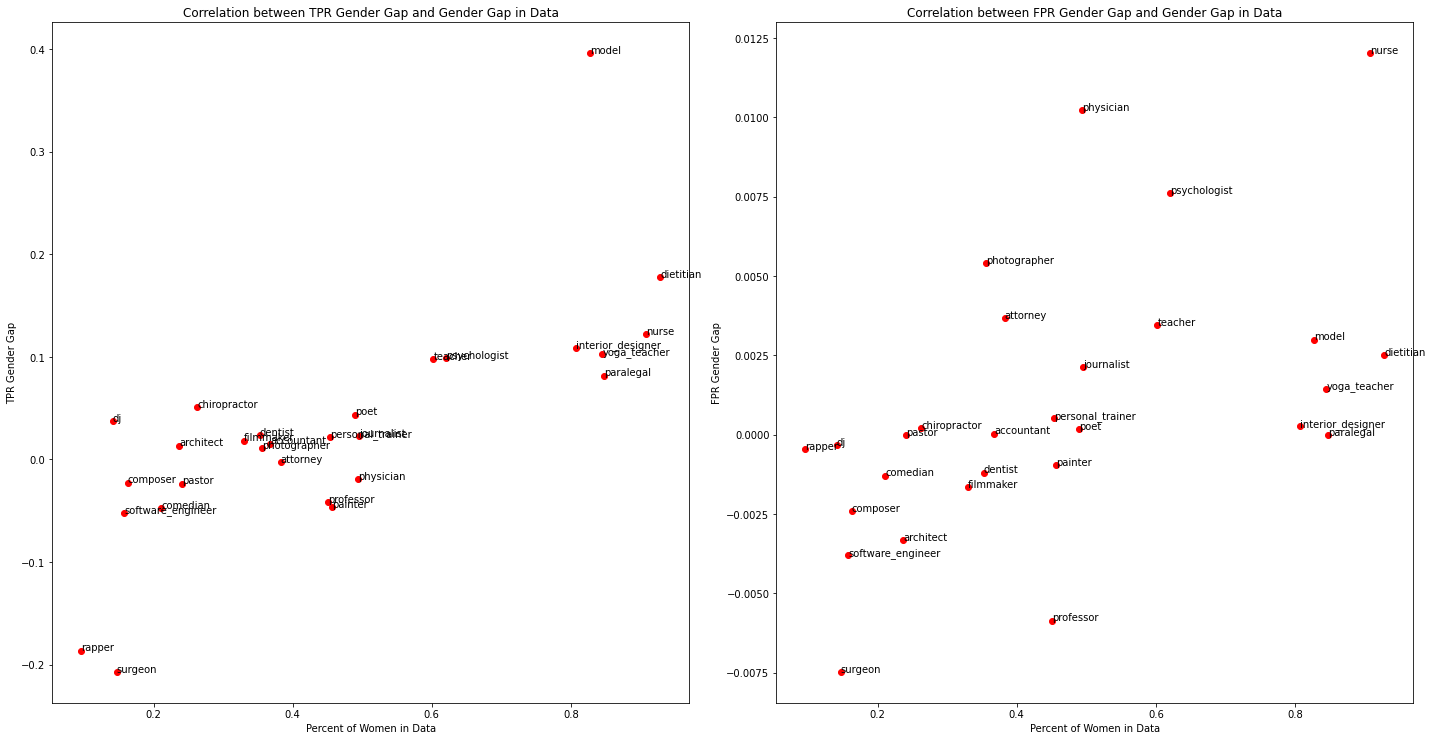

In [108]:
# LR_bio.pt
LR_inst_bio = LR(PARAMS)
LR_inst_bio.load_state_dict(torch.load("LR_bio.pt"))
LR_inst_bio.eval()
print('accuracy:',evaluate(LR_inst_bio.cpu(), test_dataset)) 
gender_analyze(LR_inst_bio,test_m,test_f,target_encoder,per_occ_women,'LR_bio')

### LR_nopre.pt

accuracy: 0.7807921756422224
aTPR: 0.11980694517751947
mTPR: 0.5175389118949022
corr_tpr: 0.8491118831247096
aFPR: 0.0037374560010914764
mFPR: 0.012940014715934756
corr_fpr: 0.607706066274376


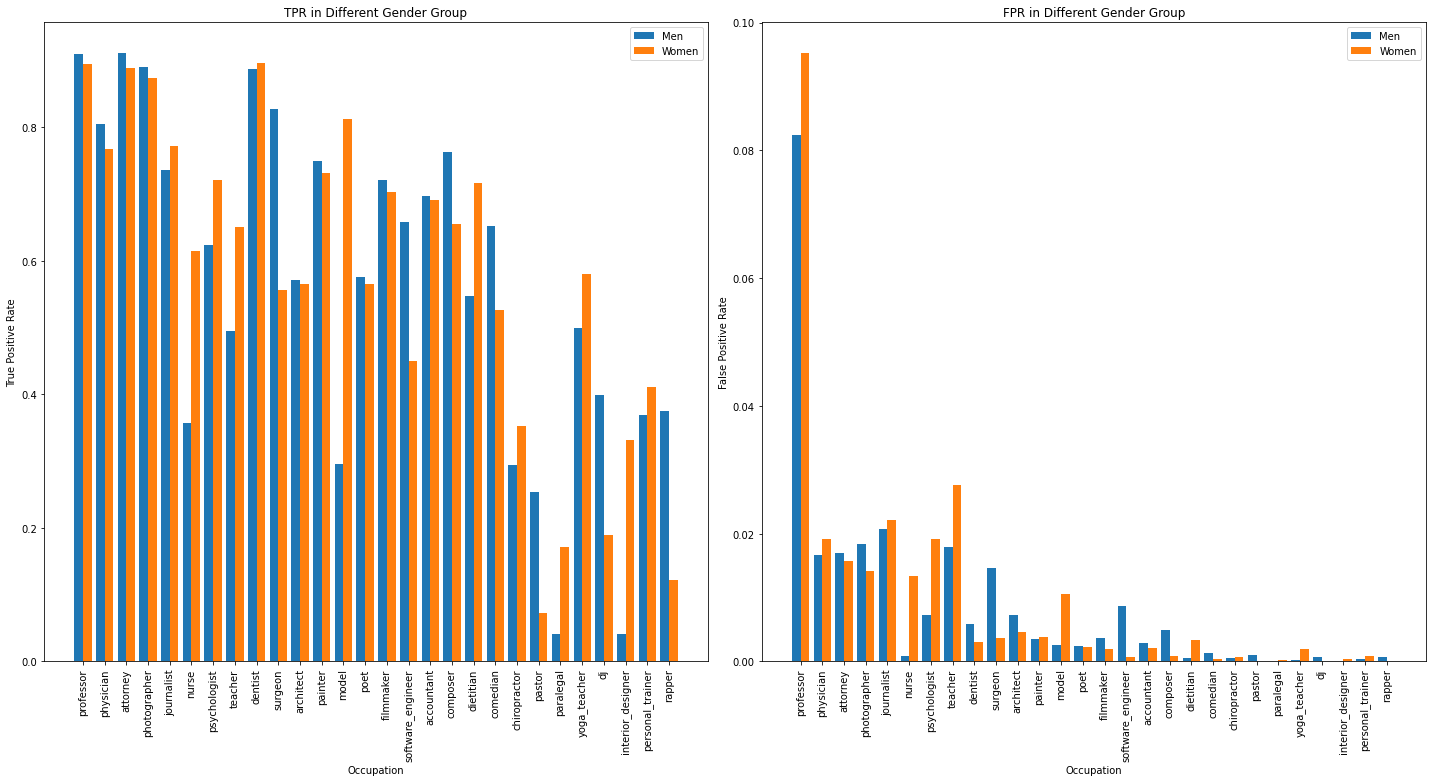

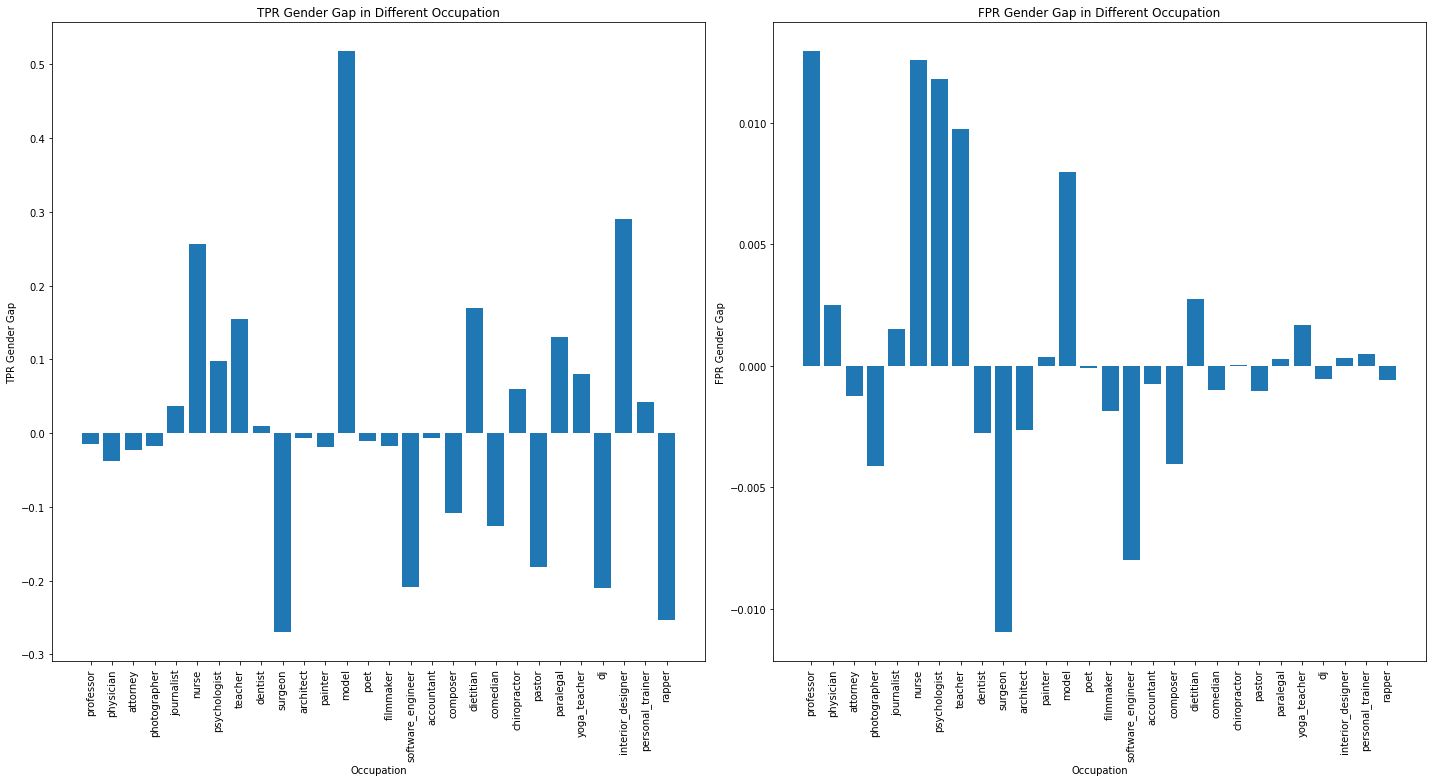

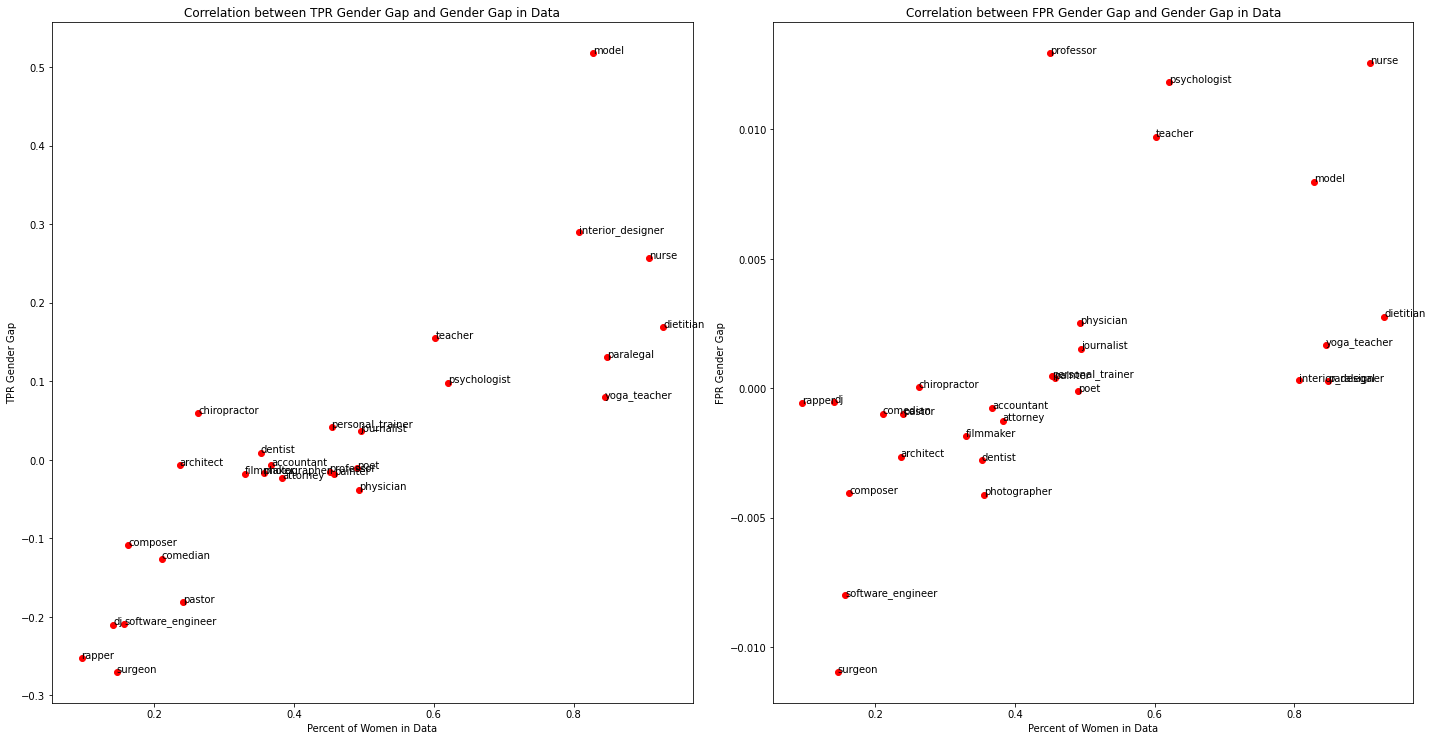

In [109]:
# LR_nopre.pt
LR_inst_nopre = LR(PARAMS)
LR_inst_nopre.load_state_dict(torch.load("LR_nopre.pt"))
LR_inst_nopre.eval()
print('accuracy:',evaluate(LR_inst_nopre.cpu(), test_dataset)) 
gender_analyze(LR_inst_nopre,test_m,test_f,target_encoder,per_occ_women,'LR_nopre')

### LR_sub.pt

accuracy: 0.7906
aTPR: 0.010572612960946637
mTPR: 0.06830981909204692
corr_tpr: 0.3229426947954524
aFPR: 0.0016549315126942674
mFPR: 0.007493947820666737
corr_fpr: -0.1577822399722449


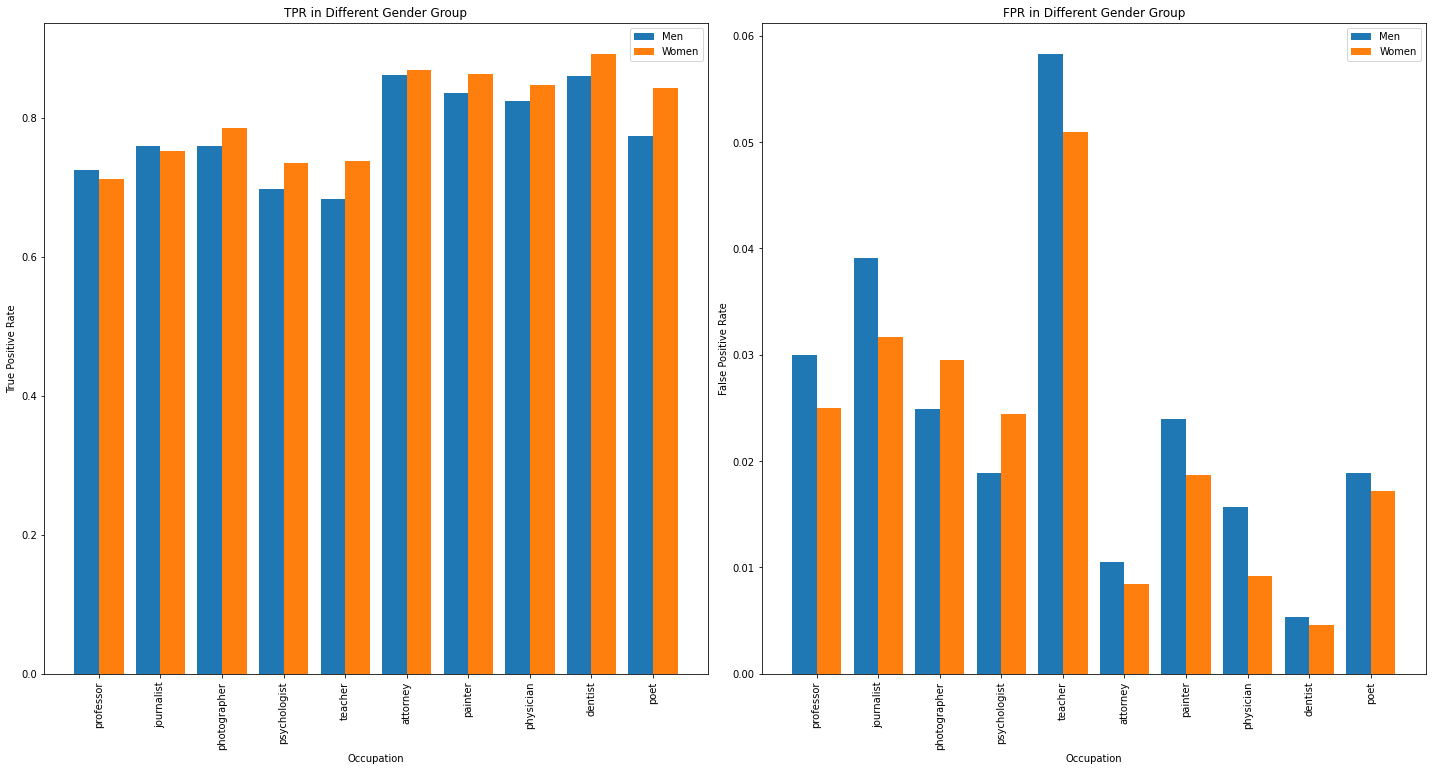

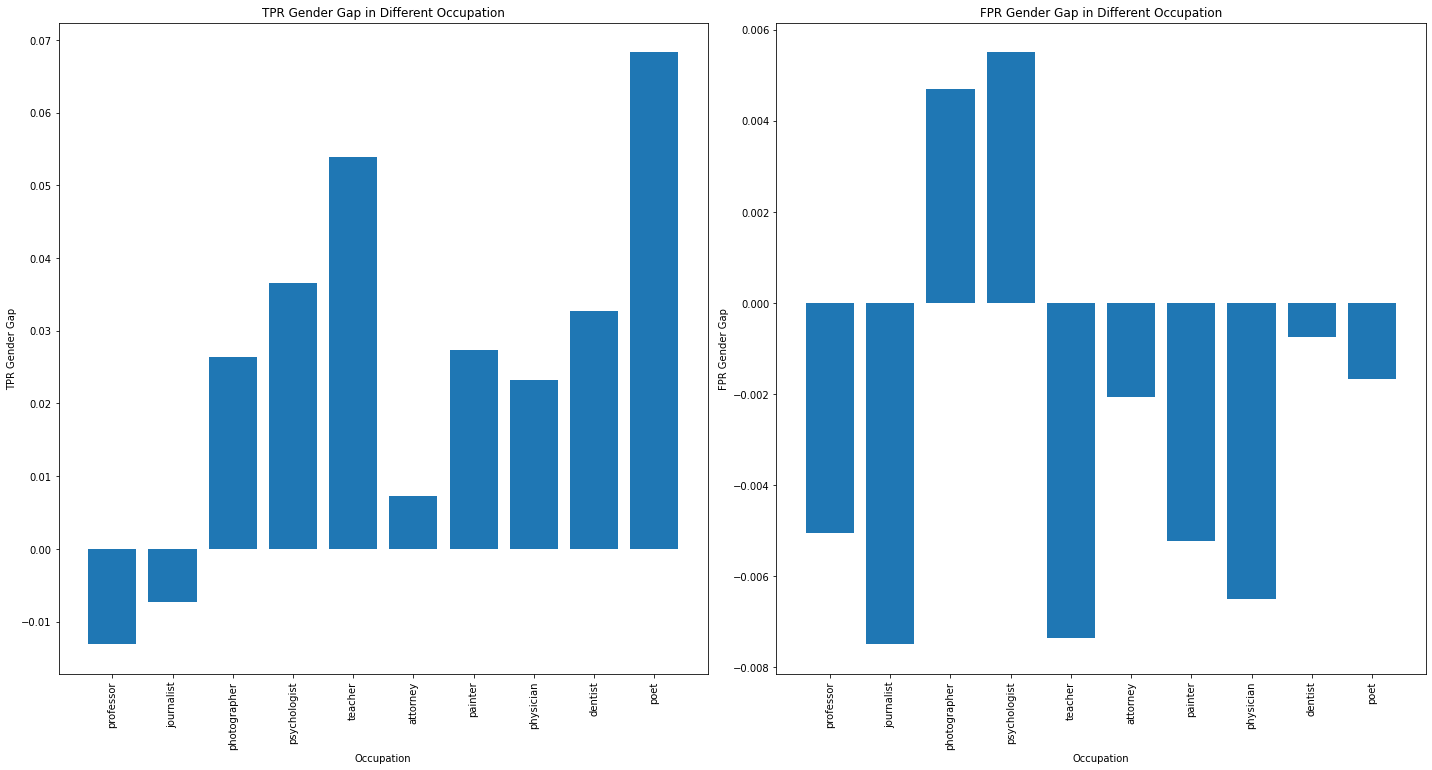

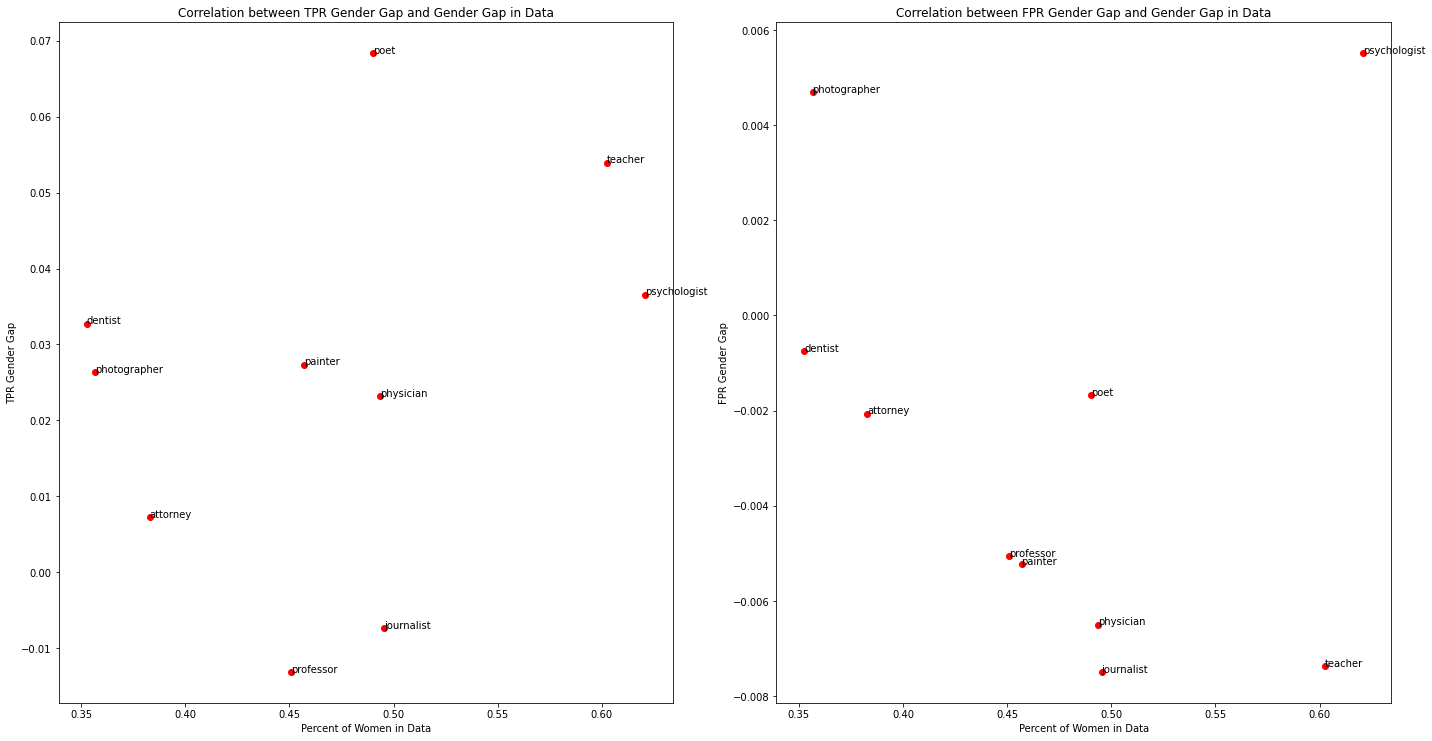

In [110]:
# LR_sub.pt
LR_inst_sub = LR(SUB_PARAMS)
LR_inst_sub.load_state_dict(torch.load("LR_sub.pt"))
LR_inst_sub.eval()
print('accuracy:',evaluate(LR_inst_sub, test_dataset_sub))
gender_analyze(LR_inst_sub,test_m_sub,test_f_sub,sub_target_encoder,sub_per_occ_women,'LR_sub')